In [62]:
import sympy as sp
import pandas as pd
import numpy as np
import math as math
import seaborn as sns
import matplotlib.pyplot as plt

In [132]:
class LinearRegression:
    def __init__(self, data, labels):
        self.data = self.__preprocess(data)
        self.labels = labels
        self.w = np.reshape(np.zeros(dtype=np.float32, shape=(self.data.shape[1])), (-1, 1))

    def train(self, type_="naive", l=0, iterations=100, verbose=False):

        if type_ == "naive":
            if verbose:
                print("Loss before modeling ", LinearRegression.__compute_loss \
                    (self.data, self.labels, self.w))
            sigma = np.matmul(np.transpose(self.data), self.data)
            sigma_inv = np.linalg.inv(sigma)
            self.w = np.matmul(np.matmul(sigma_inv, np.transpose(self.data)), \
                               np.reshape(self.labels, (-1, 1)))
            if verbose:
                print("Loss after modeling ", LinearRegression.__compute_loss \
                    (self.data, self.labels, self.w))

        if type_ == "ridge":
            if verbose:
                print("Loss before modeling ", LinearRegression.__compute_loss \
                    (self.data, self.labels, self.w))
            sigma = np.matmul(np.transpose(self.data), self.data)
            sigma_reg_inv = np.linalg.inv(l * np.eye(self.data.shape[1]) + sigma)
            self.w = np.matmul(np.matmul(sigma_reg_inv, np.transpose(self.data)), \
                               np.reshape(self.labels, (-1, 1)))
            if verbose:
                print("Loss after modeling ", LinearRegression.__compute_loss \
                    (self.data, self.labels, self.w))

        if type_ == "lasso":
            self.train(type_="ridge", l=l)
            print(self.w)
            while iterations > 0:
                for j in range(self.w.shape[0]):
                    a_j = 2 * np.sum(np.square(self.data[:, j]))
                    c_j = 0
                    for i in range(self.data.shape[0]):
                        temp2 = np.matmul(np.reshape(self.w, (1, -1)), np.reshape(self.data[i, :], (-1, 1))) \
                                - self.w[j] * self.data[i, j]
                        temp1 = (self.labels[0][i] - temp2)
                        c_j = c_j + self.data[i, j] * temp1
                    c_j = 2 * c_j
                    self.w[j] = self.__soft(a_j, c_j, l)
                print(self.w)
                iterations = iterations - 1
                print(iterations)

    def compute_rsquared(self):
        X = self.data
        y = self.labels
        w = self.w
        temp1 = np.matmul(X, w)
        temp2 = np.reshape(temp1, (1, -1)) - np.reshape(np.full(len(y), np.mean(y)), (1, -1))
        temp3 = np.square(temp2)
        temp4 = np.sum(temp3)

        temp5 = np.reshape(y, (1, -1)) - np.reshape(np.full(len(y), np.mean(y)), (1, -1))
        temp6 = np.square(temp5)
        temp7 = np.sum(temp6)
        return (temp4/temp7)

    @staticmethod
    def __compute_loss(X, y, w):
        temp1 = np.matmul(X, w)
        temp2 = np.reshape(temp1, (1, -1)) - np.reshape(y, (1, -1))
        temp3 = np.square(temp2)
        temp4 = np.sum(temp3)
        return temp4

    @staticmethod
    def __preprocess(data):
        if isinstance(data, np.ndarray):
            bias = np.ones(shape=data.shape[0])
            return np.column_stack((bias, data))
        if isinstance(data, pd.core.frame.DataFrame):
            data.insert(0, 'bias', 1)
            return data

    @staticmethod
    def __soft(a_j, c_j, l):
        print("c_j ", c_j)
        if c_j < -l:
            return (c_j + l) / a_j
        elif c_j > l:
            return (c_j - l) / a_j
        else:
            # print("Here returning 0 ")
            return 0

    def test(self, test_data, test_labels):
        test_data = self.__preprocess(test_data)
        #     error = np.sum(np.square(np.matmul(test_data, np.reshape(self.w, (-1, 1))) - \
        #             np.reshape(test_labels, (-1, 1))))
        error = np.mean(np.square(np.matmul(test_data, np.reshape(self.w, (-1, 1))) - \
                                  np.reshape(test_labels, (-1, 1))))
        return error
    
    def predict(self, data):
        data = self.__preprocess(data)
        return np.matmul(data, self.w)

In [59]:
class Logistic_Regression:
    def __init__(self, data, labels):
        self.data = self.__preprocess(data)
        self.labels = self.labels = labels
        self.w = np.zeros(dtype=np.float32, shape=(data.shape[1] + 1))

    @staticmethod
    def __preprocess(data):
        bias = np.ones(shape=data.shape[0])
        return pd.DataFrame(np.column_stack((bias, data)))

    @staticmethod
    def __sigmoid(x):
        try:
            value = 1 / (1 + round(math.exp(-x), 8))
        except OverflowError:
            print("Overflown with x as ", x)
        return value

    @staticmethod
    def __predict(x_i, w):
        dot_product = np.inner(x_i, w)
        return Logistic_Regression.__sigmoid(dot_product)

    def __sgd(self, data, labels, num_iters, alpha, beta=0, gamma=0, verbose=False):
        for j in range(num_iters):
            if verbose:
                print("Loss in iter ", j, " is ", Logistic_Regression.__compute_loss(data, labels, self.w, beta))
            for i in range(len(labels)):
                prediction = Logistic_Regression.__predict(data.iloc[i, :], self.w)
                temp_label = labels[i]
                temp_data = data.iloc[i, :]
                temp_product = np.multiply(data.iloc[i, :], (labels[i] - prediction)).reshape(1, -1)
                self.w = self.w - (alpha * temp_product) - beta * self.w

    @staticmethod
    def __compute_loss(data: pd.DataFrame, y, w, beta=0):
        x_y = pd.DataFrame(np.column_stack((data, y)))
        # loss = x_y.apply(lambda x: print(x.iloc[-1]), axis=1)
        loss = x_y.apply(lambda x: math.log(Logistic_Regression.__predict(x[:-1], w)**x.iloc[-1]*\
                                      (1-Logistic_Regression.__predict(x[:-1],w))**(1-x.iloc[-1])), axis=1)
        loss_ = np.sum(np.sum(loss) - beta * np.inner(w, w))
        return loss_

    def train(self, type_="naive", alpha=0, beta = 0, gamma = 0, iterations=10, verbose = False):

        if type_ == "naive":
            self.w = self.__sgd(self.data, self.labels, iterations, alpha=alpha, verbose=True)
        elif type_ == "ridge":
            self.w  = self.__sgd(self.data, self.labels, iterations, alpha=alpha, beta=beta, verbose=True)


In [5]:
file_name = "Tab.delimited.Cleaned.dataset.WITH.variable.labels"
df = pd.read_csv(r"ML1/" + file_name + ".preprocessed_hot" + ".csv", sep=',', encoding='utf-8', low_memory=False)

df_correlation = df.corr()

np.set_printoptions(suppress=True)

parent_array = []
def quick_union(p, q, parent_array):
    pid = parent_array[p]
    qid = parent_array[q]
    
    for k in range(len(parent_array)):
        if parent_array[k] == pid:
            parent_array[k] = qid

# with open(r"mutual_info_matrix.pkl", "rb") as f:
#     arr_temp = pk.load(f)
    
# print(arr_temp)    

arr2 = []
arr_temp = df_correlation.values.tolist()
for i in range(len(arr_temp)):
    arr3 = []
    j = 0
    for j in range(len(arr_temp[i])):
        if abs(arr_temp[i][j]) > 0.35:
            arr3.append(1)
        else:
            arr3.append(0)
    arr2.append(arr3)        
            
for i in range(len(arr2)):
    parent_array.append(i)
    
for i in range(len(arr2)):
    for j in range(i, len(arr2), 1):
        if arr2[i][j] == 1:
            quick_union(i, j, parent_array)
            
temppp = ((np.array(parent_array)))
print(temppp)

[157 157 157 157 157 157 157 157 157 157 157  11 131  13  73  62  64  66
  68  62  64  66  68  62  64  66  68  27  91  29 129 129 129  33 127 127
  60  60 121 121  40 121  89 118 157  82  46 140  48 187  50 107 166 130
 110 110 110 166 166  60  60  62  62  64  64  66  66  68  68 110 157 165
  73  73  74  82  82  82  82  82  82  82  82 157  85  85  86  89  88  89
  91  91 110 110 110 110 110 110 110 110 110 110 110 110 107 107 107 107
 108 157 110 157 130 130 157 115 118 117 118 119 120 121 122 123 127 127
 127 127 128 129 130 131 132 140 140 135 140 140 140 139 140 166 157 157
 157 157 157 157 157 157 157 157 157 157 157 157 157 157 157 159 160 163
 163 163 164 165 166 187 183 181 180 178 185 182 184 179 186 188 178 179
 180 181 182 183 184 185 186 187 188]


The above is the disjoint set display of all the variables, based on correlation matrix.

The total number of disjoint sets that we have is:

In [133]:
len(pd.DataFrame(temppp)[0].unique())

60

In [7]:
unique_set = {}
for i in range(len(temppp)):
    if temppp[i] in unique_set.keys():
        unique_set[temppp[i]].append(i)
    else:
        unique_set[temppp[i]] = [i]

The sets, displayed as key value pairs

In [8]:
unique_set

{11: [11],
 13: [13],
 27: [27],
 29: [29],
 33: [33],
 40: [40],
 46: [46],
 48: [48],
 50: [50],
 60: [36, 37, 59, 60],
 62: [15, 19, 23, 61, 62],
 64: [16, 20, 24, 63, 64],
 66: [17, 21, 25, 65, 66],
 68: [18, 22, 26, 67, 68],
 73: [14, 72, 73],
 74: [74],
 82: [45, 75, 76, 77, 78, 79, 80, 81, 82],
 85: [84, 85],
 86: [86],
 88: [88],
 89: [42, 87, 89],
 91: [28, 90, 91],
 107: [51, 104, 105, 106, 107],
 108: [108],
 110: [54,
  55,
  56,
  69,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  110],
 115: [115],
 117: [117],
 118: [43, 116, 118],
 119: [119],
 120: [120],
 121: [38, 39, 41, 121],
 122: [122],
 123: [123],
 127: [34, 35, 124, 125, 126, 127],
 128: [128],
 129: [30, 31, 32, 129],
 130: [53, 112, 113, 130],
 131: [12, 131],
 132: [132],
 135: [135],
 139: [139],
 140: [47, 133, 134, 136, 137, 138, 140],
 157: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  44,
  70,
  83,
  109,
  111,
  114,
  142,
  143,
  144,
  145,
  146,
  147

In [9]:
regression_cols = ['Ranch1', 'Ranch2', 'Ranch3', 'Ranch4', 'age', \
                  'numparticipants', 'numparticipants_actual', 'sunkDV', 'anchoring1', 'anchoring2', \
                  'anchoring3', 'anchoring4', 'gambfalDV', 'quotearec', 'quotebrec', 'quote', \
                  'totalflagestimations', 'totalnoflagtimeestimations', 'flagdv', 'Sysjust', 'Imagineddv', \
                  'IATexpart', 'IATexpmath', 'IATexp.overall', 'artwarm', 'd_donotuse', 'gamblerfallacya', \
                  'gamblerfallacyb', 'mathwarm', 'moneyagea', 'sample', 'citizenship']
regression_cols.extend(['anchoring'+str(i)+'a' for i in range(1, 5)])
regression_cols.extend(['anchoring'+str(i)+'b' for i in range(1, 5)])
regression_cols.extend(['flagdv'+str(i) for i in range(1, 9)])
regression_cols.extend(['iatexplicitmath'+str(i) for i in range(1, 7)])
regression_cols.extend(['imaginedexplicit'+str(i) for i in range(1, 5)])

In [10]:
unique_set_regression = {}
for key in unique_set.keys():
    for vals in unique_set[key]:
        if df.columns[vals] in regression_cols:
            if df.columns[key]+" "+str(key) not in unique_set_regression.keys():
                unique_set_regression[df.columns[key]+" "+str(key)] = [df.columns[vals]]
            else:
                unique_set_regression[df.columns[key]+" "+str(key)].append(df.columns[vals])

In [11]:
unique_set_regression

{'anchoring1b 62': ['anchoring1', 'Ranch1', 'anchoring1a', 'anchoring1b'],
 'anchoring2b 64': ['anchoring2', 'Ranch2', 'anchoring2a', 'anchoring2b'],
 'anchoring3b 66': ['anchoring3', 'Ranch3', 'anchoring3a', 'anchoring3b'],
 'anchoring4b 68': ['anchoring4', 'Ranch4', 'anchoring4a', 'anchoring4b'],
 'flagdv8 82': ['flagdv',
  'flagdv1',
  'flagdv2',
  'flagdv3',
  'flagdv4',
  'flagdv5',
  'flagdv6',
  'flagdv7',
  'flagdv8'],
 'flagtimeestimate4 89': ['totalflagestimations'],
 'gamblerfallacyb 91': ['gambfalDV', 'gamblerfallacya', 'gamblerfallacyb'],
 'imaginedexplicit4 107': ['Imagineddv',
  'imaginedexplicit1',
  'imaginedexplicit2',
  'imaginedexplicit3',
  'imaginedexplicit4'],
 'mathwarm 110': ['IATexpart',
  'IATexpmath',
  'IATexp.overall',
  'artwarm',
  'iatexplicitmath1',
  'iatexplicitmath2',
  'iatexplicitmath3',
  'iatexplicitmath4',
  'iatexplicitmath5',
  'iatexplicitmath6',
  'mathwarm'],
 'noflagtimeestimate4 118': ['totalnoflagtimeestimations'],
 'order 165': ['d_don

The number of features in each set

In [60]:
pd.DataFrame(temppp)[0].value_counts()

157    34
110    17
82      9
140     7
127     6
66      5
62      5
64      5
166     5
68      5
107     5
130     4
121     4
60      4
129     4
118     3
187     3
163     3
91      3
89      3
73      3
188     2
85      2
131     2
178     2
186     2
185     2
184     2
183     2
182     2
181     2
180     2
179     2
165     2
40      1
13      1
27      1
29      1
50      1
33      1
48      1
74      1
46      1
120     1
86      1
88      1
108     1
115     1
117     1
119     1
122     1
123     1
128     1
132     1
135     1
139     1
159     1
160     1
164     1
11      1
Name: 0, dtype: int64

In [178]:
file_name = "Tab.delimited.Cleaned.dataset.WITH.variable.labels"
df = pd.read_csv(r"ML1/" + file_name + ".preprocessed_hot" + ".csv", sep=',', encoding='utf-8', low_memory=False)
df_correlation = df.corr()
np.set_printoptions(suppress=True)

The matrix on which we impute values using our best model.

In [179]:
imputed_df = df.copy(deep=True)

In [180]:
parent_array = []
def quick_union(p, q, parent_array):
    pid = parent_array[p]
    qid = parent_array[q]

    for k in range(len(parent_array)):
        if parent_array[k] == pid:
            parent_array[k] = qid

arr2 = []
arr_temp = df_correlation.values.tolist()
for i in range(len(arr_temp)):
    arr3 = []
    j = 0
    for j in range(len(arr_temp[i])):
        if abs(arr_temp[i][j]) > 0.35:
            arr3.append(1)
        else:
            arr3.append(0)
    arr2.append(arr3)

for i in range(len(arr2)):
    parent_array.append(i)

for i in range(len(arr2)):
    for j in range(i, len(arr2), 1):
        if arr2[i][j] == 1:
            quick_union(i, j, parent_array)

temppp = ((np.array(parent_array)))

unique_set = {}
for i in range(len(temppp)):
    if temppp[i] in unique_set.keys():
        unique_set[temppp[i]].append(i)
    else:
        unique_set[temppp[i]] = [i]

regression_cols = ['Ranch1', 'Ranch2', 'Ranch3', 'Ranch4', 'age', \
                  'numparticipants', 'numparticipants_actual', 'sunkDV', 'anchoring1', 'anchoring2', \
                  'anchoring3', 'anchoring4', 'gambfalDV', 'quotearec', 'quotebrec', 'quote', \
                  'totalflagestimations', 'totalnoflagtimeestimations', 'flagdv', 'Sysjust', 'Imagineddv', \
                  'IATexpart', 'IATexpmath', 'IATexp.overall', 'artwarm', 'd_donotuse', 'gamblerfallacya', \
                  'gamblerfallacyb', 'mathwarm', 'moneyagea', 'sample', 'citizenship']
regression_cols.extend(['anchoring'+str(i)+'a' for i in range(1, 5)])
regression_cols.extend(['anchoring'+str(i)+'b' for i in range(1, 5)])
regression_cols.extend(['flagdv'+str(i) for i in range(1, 9)])
regression_cols.extend(['iatexplicitmath'+str(i) for i in range(1, 7)])
regression_cols.extend(['imaginedexplicit'+str(i) for i in range(1, 5)])

In [197]:
regression_cols

['Ranch1',
 'Ranch2',
 'Ranch3',
 'Ranch4',
 'age',
 'numparticipants',
 'numparticipants_actual',
 'sunkDV',
 'anchoring1',
 'anchoring2',
 'anchoring3',
 'anchoring4',
 'gambfalDV',
 'quotearec',
 'quotebrec',
 'quote',
 'totalflagestimations',
 'totalnoflagtimeestimations',
 'flagdv',
 'Sysjust',
 'Imagineddv',
 'IATexpart',
 'IATexpmath',
 'IATexp.overall',
 'artwarm',
 'd_donotuse',
 'gamblerfallacya',
 'gamblerfallacyb',
 'mathwarm',
 'moneyagea',
 'sample',
 'citizenship',
 'anchoring1a',
 'anchoring2a',
 'anchoring3a',
 'anchoring4a',
 'anchoring1b',
 'anchoring2b',
 'anchoring3b',
 'anchoring4b',
 'flagdv1',
 'flagdv2',
 'flagdv3',
 'flagdv4',
 'flagdv5',
 'flagdv6',
 'flagdv7',
 'flagdv8',
 'iatexplicitmath1',
 'iatexplicitmath2',
 'iatexplicitmath3',
 'iatexplicitmath4',
 'iatexplicitmath5',
 'iatexplicitmath6',
 'imaginedexplicit1',
 'imaginedexplicit2',
 'imaginedexplicit3',
 'imaginedexplicit4']

## Set 110
We do a separate analysis for set 110, which has features as mentioned above. This is for explanatory purposes.

In [243]:
#set 110
set_no = 110
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)
    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  1.0
Error on test set is:  1.57058820887e-23

R2 is:  0.99896894559
Error on test set is:  1.12763028642e-05

R2 is:  0.998016352647
Error on test set is:  4.24599710234e-05

R2 is:  0.997133975911
Error on test set is:  9.00917618965e-05

R2 is:  0.996314654108
Error on test set is:  0.000151290423226

R2 is:  0.995552140891
Error on test set is:  0.000223648571498

R2 is:  0.994840966069
Error on test set is:  0.000305149094481

R2 is:  0.994176320983
Error on test set is:  0.000394097665607

R2 is:  0.993553963302
Error on test set is:  0.000489067984786

R2 is:  0.992970137609
Error on test set is:  0.000588857129989

R2 is:  0.99242150879
Error on test set is:  0.000692448988193

R2 is:  0.99190510591
Error on test set is:  0.000798984173475

R2 is:  0.991418274733
Error on test set is:  0.000907735182071

R2 is:  0.990958637378
Error on test set is:  0.0010180857933

R2 is:  0.99052405791
Error on test set is:  0.00112951392987

R2 is:  0.990112612876
Error on test set is

R2 is:  1.00118369688
Error on test set is:  8.00707679884e-05

R2 is:  1.00121126981
Error on test set is:  8.3564391078e-05

R2 is:  1.0012388938
Error on test set is:  8.71281118267e-05

R2 is:  1.00126656861
Error on test set is:  9.07616602847e-05

R2 is:  1.001294294
Error on test set is:  9.44647675959e-05

R2 is:  2.66530862429
Error on test set is:  1049.01261763

R2 is:  0.687534550972
Error on test set is:  169.4204934

R2 is:  0.687524734431
Error on test set is:  169.421323589

R2 is:  0.687514925862
Error on test set is:  169.422154037

R2 is:  0.687505124935
Error on test set is:  169.422984766

R2 is:  0.687495331656
Error on test set is:  169.423815773

R2 is:  0.687485546121
Error on test set is:  169.424647061

R2 is:  0.68747576824
Error on test set is:  169.42547862

R2 is:  0.687465997994
Error on test set is:  169.426310449

R2 is:  0.687456235421
Error on test set is:  169.427142551

R2 is:  0.687446480444
Error on test set is:  169.427974921

R2 is:  0.68743673

Error on test set is:  0.260358089258

R2 is:  0.834430917752
Error on test set is:  0.260336355714

R2 is:  0.834321498798
Error on test set is:  0.260314665663

R2 is:  0.834212146961
Error on test set is:  0.260293019053

R2 is:  0.834102862164
Error on test set is:  0.260271415835

R2 is:  0.83399364437
Error on test set is:  0.26024985596

R2 is:  0.833884493505
Error on test set is:  0.260228339377

R2 is:  0.833775409525
Error on test set is:  0.260206866036

R2 is:  0.833666392368
Error on test set is:  0.260185435887

R2 is:  0.833557441985
Error on test set is:  0.260164048883

R2 is:  0.833448558311
Error on test set is:  0.260142704971

R2 is:  0.833339741302
Error on test set is:  0.260121404102

R2 is:  0.833230990898
Error on test set is:  0.26010014623

R2 is:  0.833122307036
Error on test set is:  0.260078931303

R2 is:  0.833013689671
Error on test set is:  0.26005775927

R2 is:  0.832905138745
Error on test set is:  0.260036630083

R2 is:  12.1540537378
Error on test

R2 is:  0.850108179339
Error on test set is:  0.309911709878

R2 is:  0.850013666241
Error on test set is:  0.309900408644

R2 is:  0.849919213549
Error on test set is:  0.309889147831

R2 is:  0.849824821212
Error on test set is:  0.309877927391

R2 is:  6.27811654686
Error on test set is:  12.2423531023

R2 is:  0.845998914846
Error on test set is:  0.408215907522

R2 is:  0.845868400762
Error on test set is:  0.408191849479

R2 is:  0.845737937958
Error on test set is:  0.408167832191

R2 is:  0.845607526313
Error on test set is:  0.408143855615

R2 is:  0.845477165826
Error on test set is:  0.408119919733

R2 is:  0.845346856514
Error on test set is:  0.408096024511

R2 is:  0.845216598307
Error on test set is:  0.408072169928

R2 is:  0.845086391216
Error on test set is:  0.408048355961

R2 is:  0.844956235152
Error on test set is:  0.408024582553

R2 is:  0.844826130159
Error on test set is:  0.408000849694

R2 is:  0.844696076145
Error on test set is:  0.407977157337

R2 is:  0.

R2 is:  0.643651257972
Error on test set is:  1.02524827121

R2 is:  0.643651471857
Error on test set is:  1.0252506362

R2 is:  0.643651685742
Error on test set is:  1.02525300033

R2 is:  0.643651899622
Error on test set is:  1.0252553636

R2 is:  0.643652113499
Error on test set is:  1.02525772601

R2 is:  0.643652327372
Error on test set is:  1.02526008756

R2 is:  0.643652541242
Error on test set is:  1.02526244825

R2 is:  0.643652755109
Error on test set is:  1.02526480809

R2 is:  0.64365296897
Error on test set is:  1.02526716706

R2 is:  0.643653182828
Error on test set is:  1.02526952518

R2 is:  0.64365339668
Error on test set is:  1.02527188245

R2 is:  0.643653610528
Error on test set is:  1.02527423886

R2 is:  0.643653824371
Error on test set is:  1.02527659442

R2 is:  0.643654038208
Error on test set is:  1.02527894912

R2 is:  0.643654252039
Error on test set is:  1.02528130296

R2 is:  0.643654465866
Error on test set is:  1.02528365596

R2 is:  0.643654679686
Error

Error on test set is:  1.18031120067

R2 is:  0.593238801452
Error on test set is:  1.18031051908

R2 is:  0.593238874731
Error on test set is:  1.18030983957

R2 is:  0.593238948287
Error on test set is:  1.18030916214

R2 is:  0.593239022126
Error on test set is:  1.18030848678

R2 is:  0.593239096244
Error on test set is:  1.18030781349

R2 is:  0.59323917064
Error on test set is:  1.18030714226

R2 is:  0.593239245314
Error on test set is:  1.18030647309

R2 is:  0.593239320264
Error on test set is:  1.18030580597

R2 is:  0.593239395491
Error on test set is:  1.18030514089

R2 is:  0.593239470992
Error on test set is:  1.18030447786

R2 is:  0.593239546767
Error on test set is:  1.18030381687

R2 is:  0.593239622815
Error on test set is:  1.18030315791

R2 is:  0.593239699135
Error on test set is:  1.18030250098

R2 is:  0.593239775726
Error on test set is:  1.18030184608

R2 is:  0.593239852587
Error on test set is:  1.18030119319

R2 is:  0.593239929718
Error on test set is:  1.

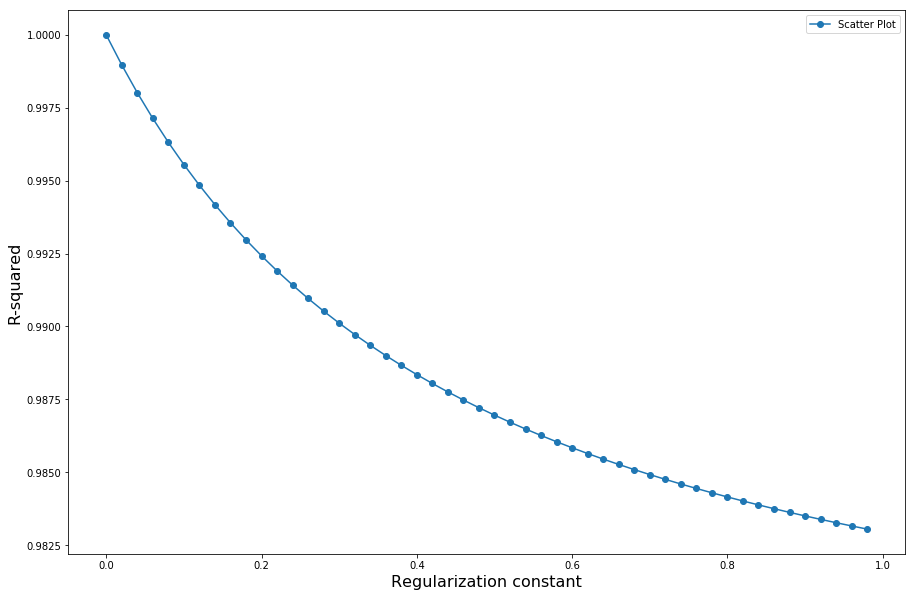

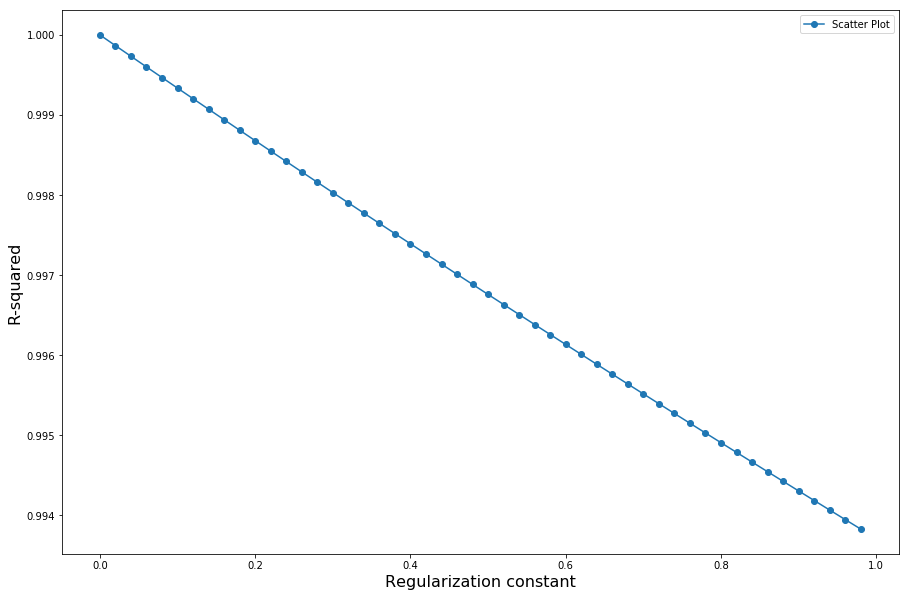

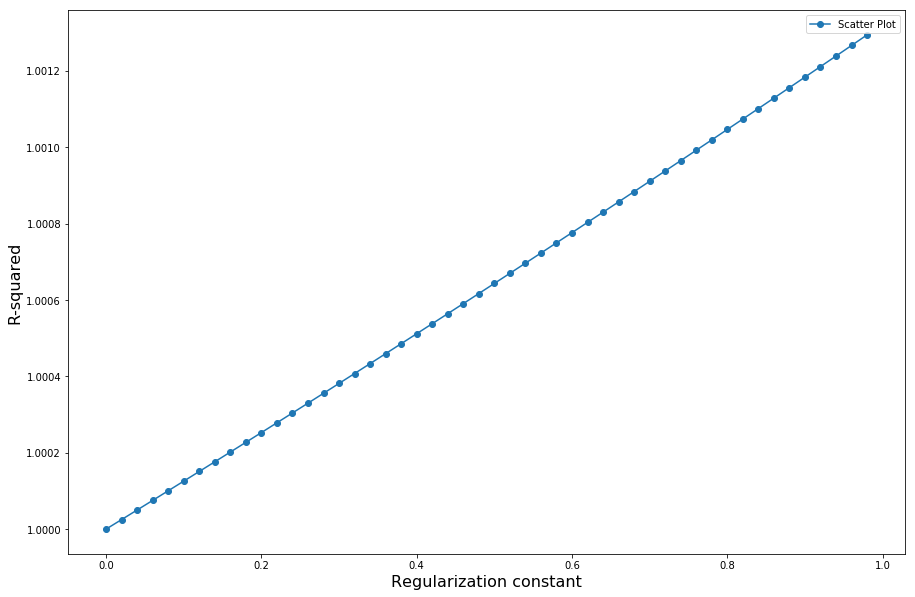

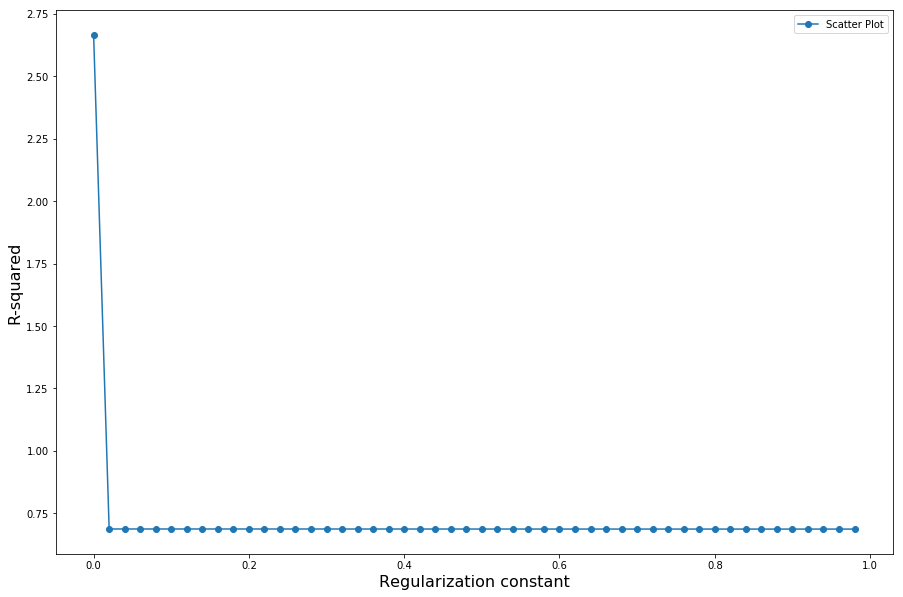

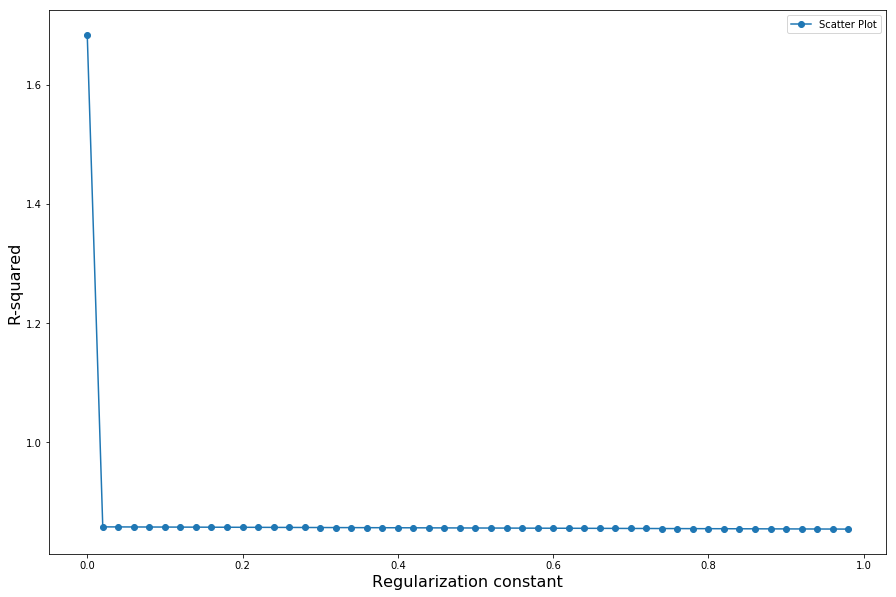

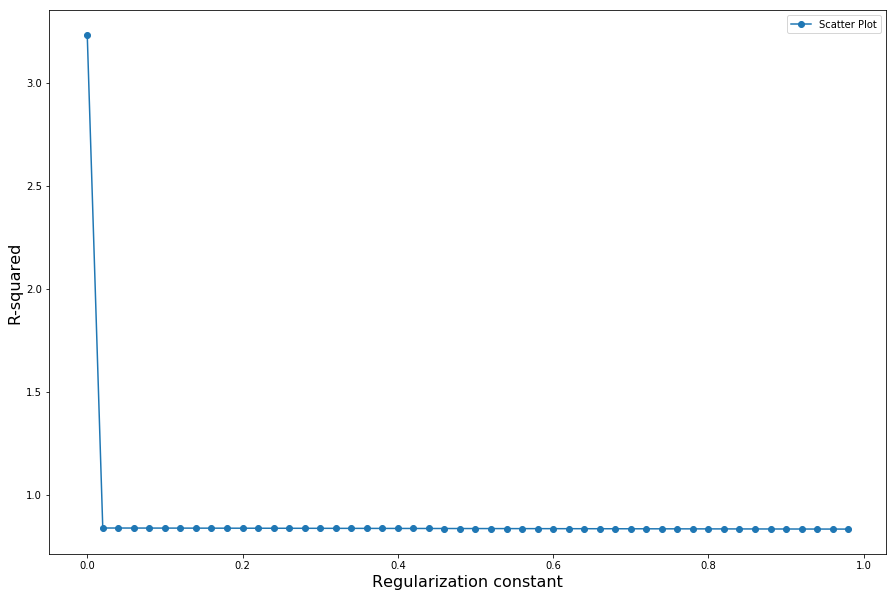

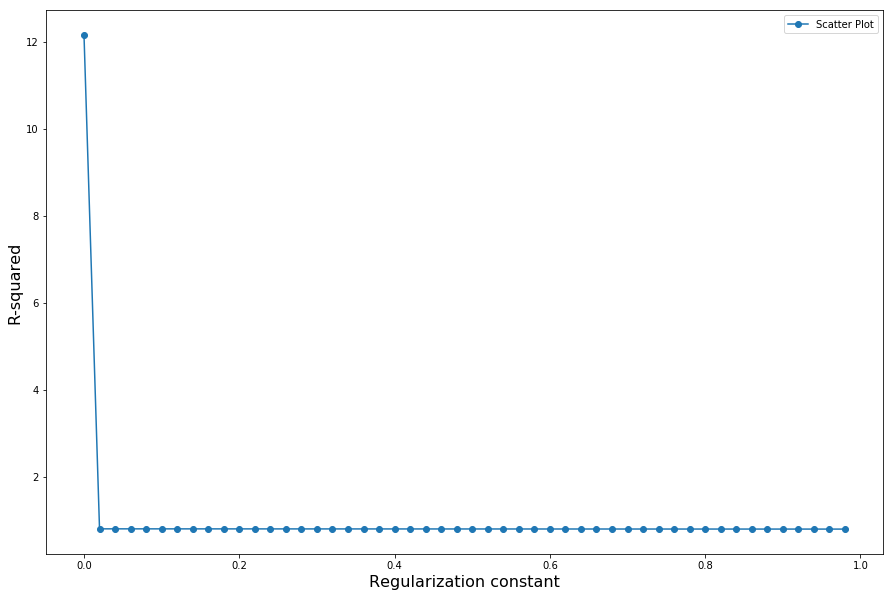

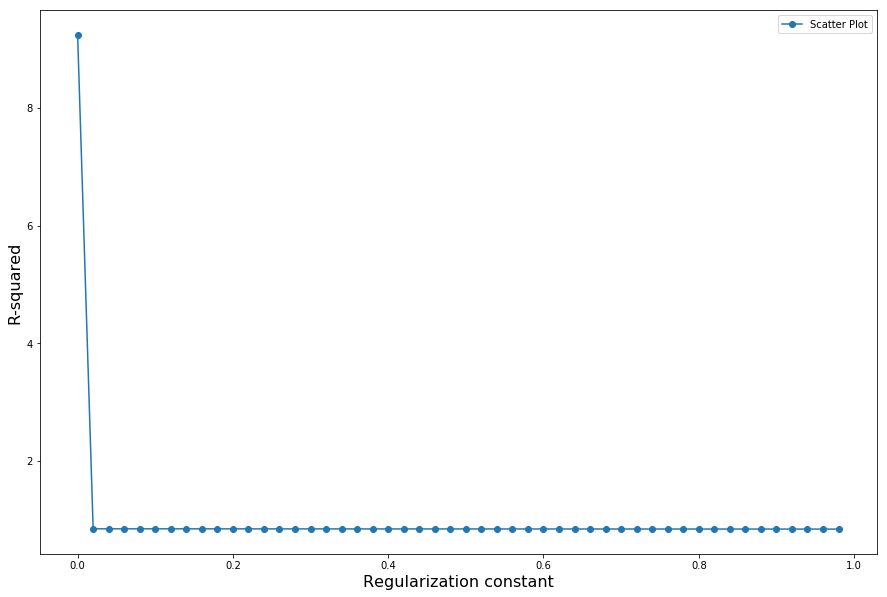

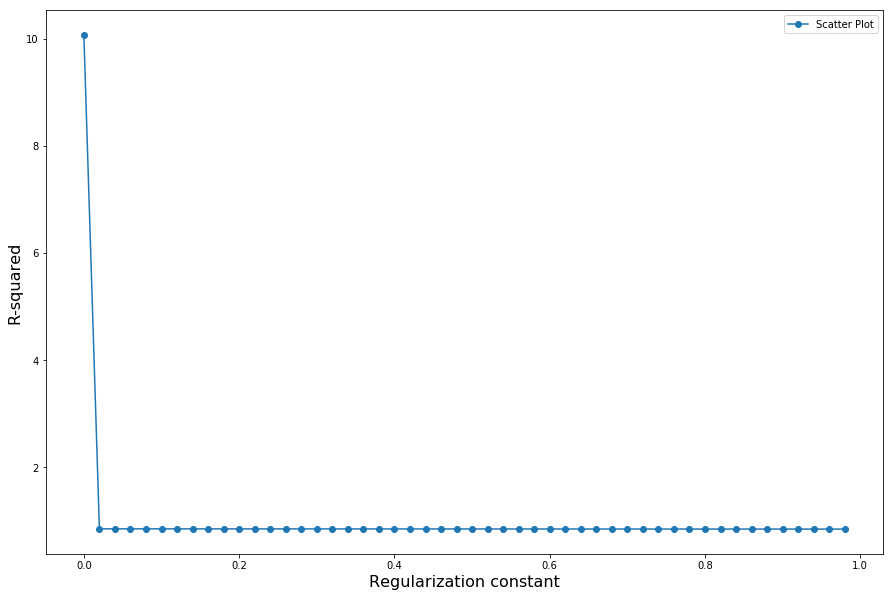

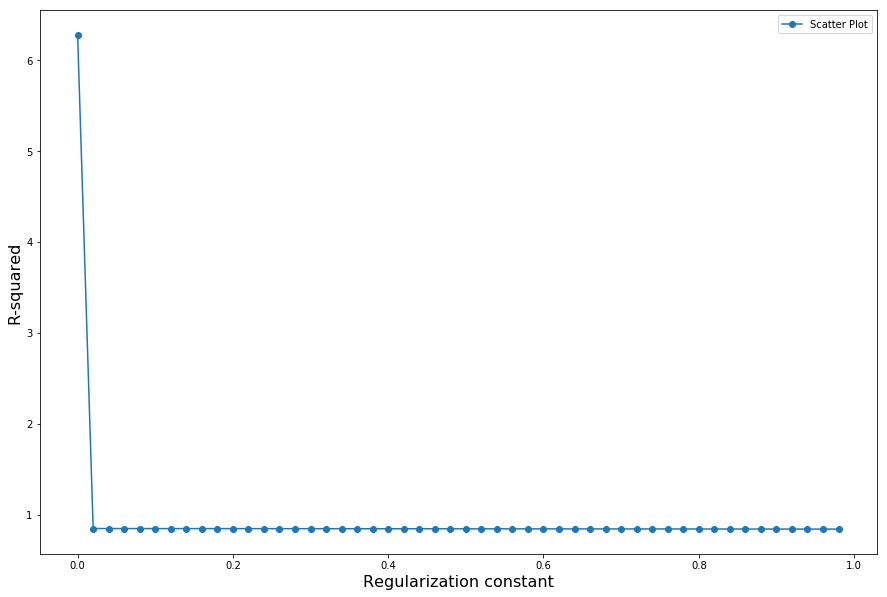

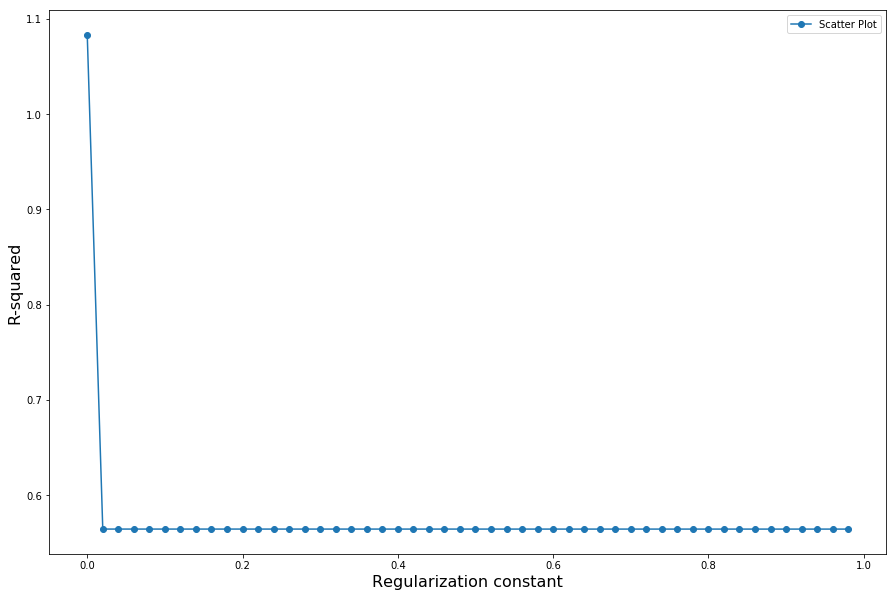

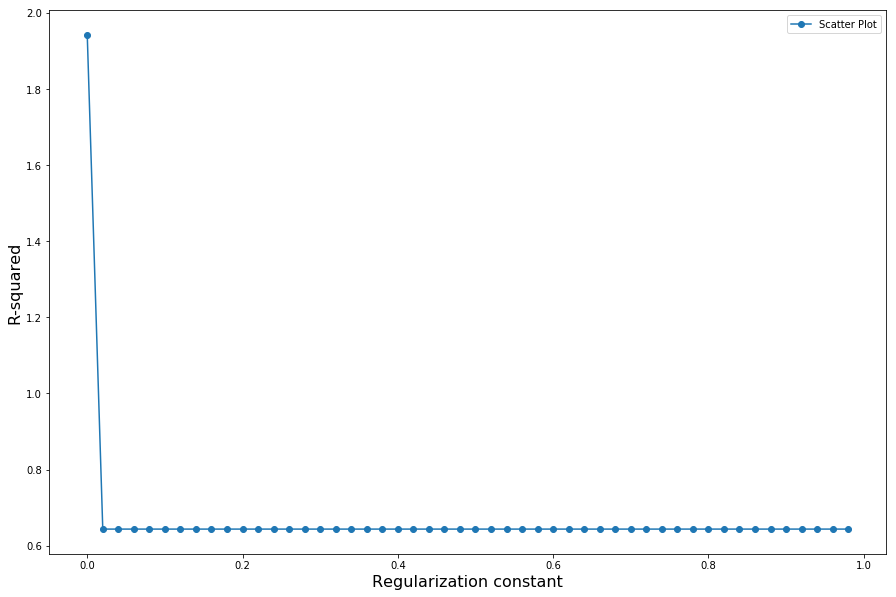

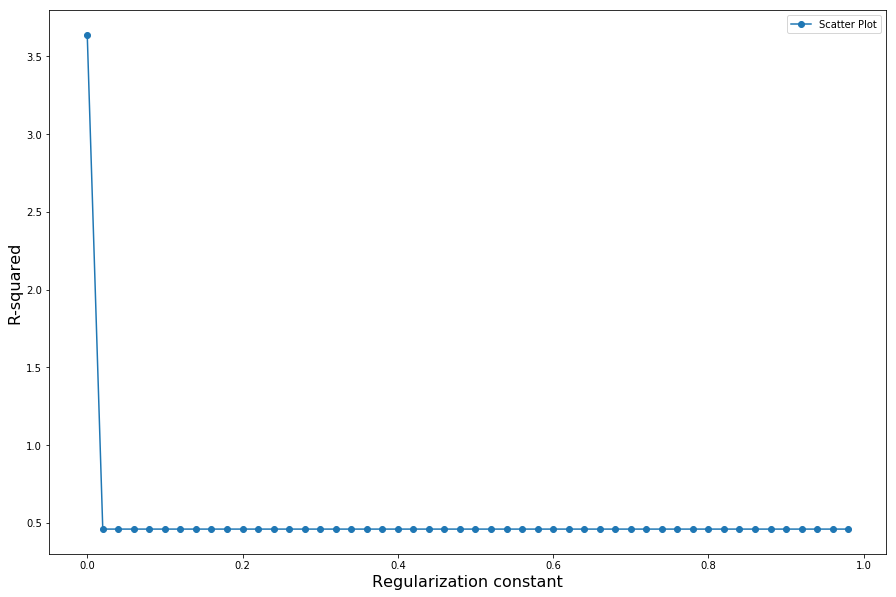

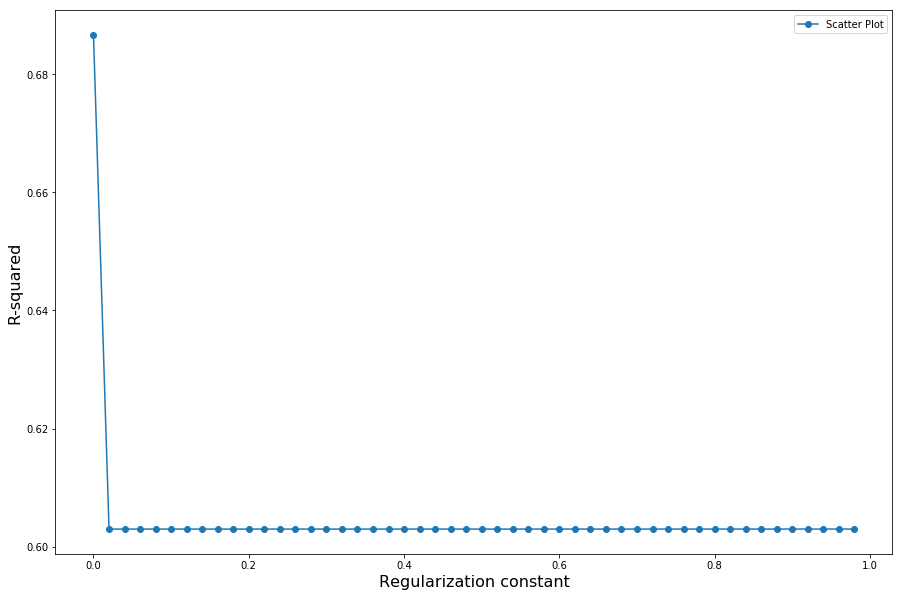

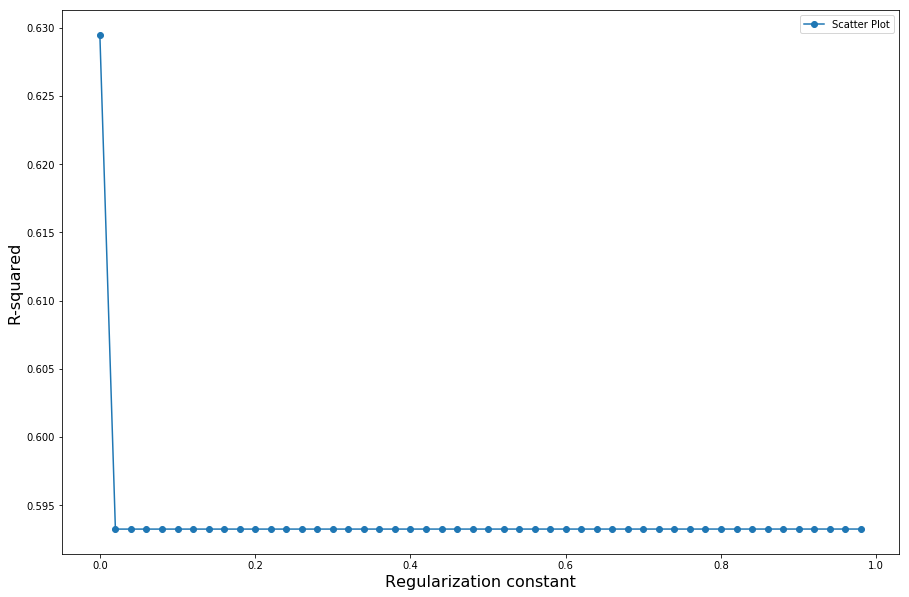

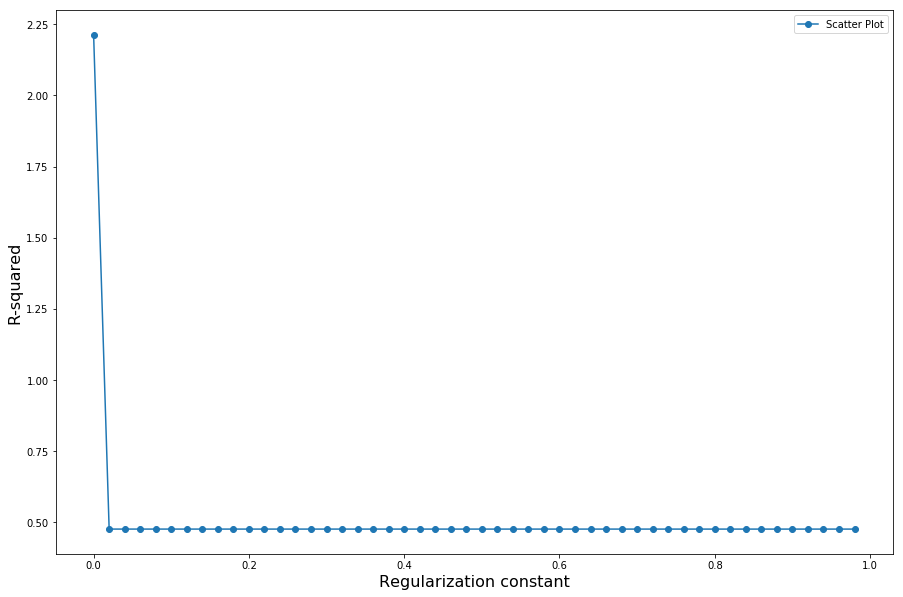

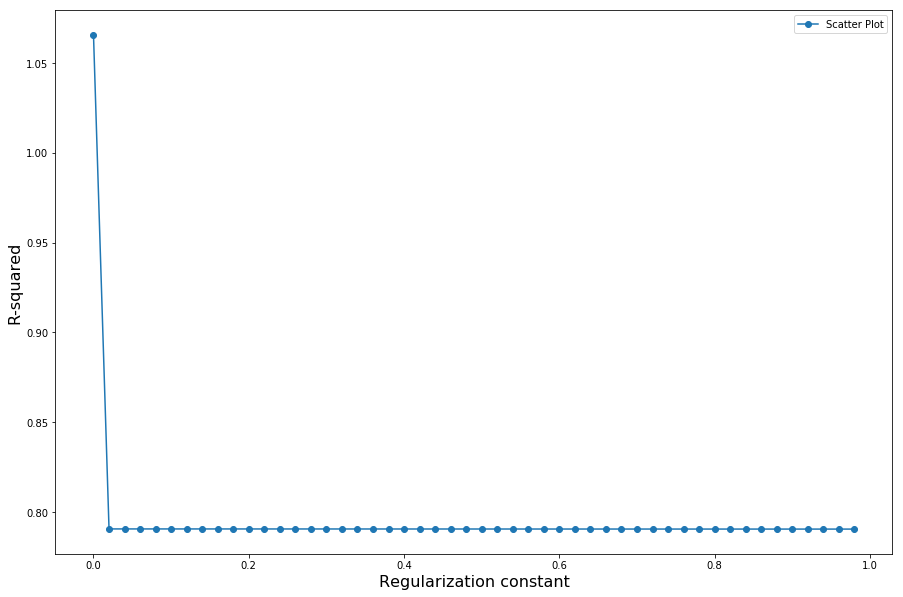

In [182]:
for i in range(len(r2)):
    fig = plt.figure(figsize=(15, 10))
    fig1 = plt.plot(l_iterable, r2[i], "-o", label = "Scatter Plot")
    plt.legend()
    plt.xlabel("Regularization constant", fontsize=16)
    plt.ylabel("R-squared", fontsize=16)
    plt.show()

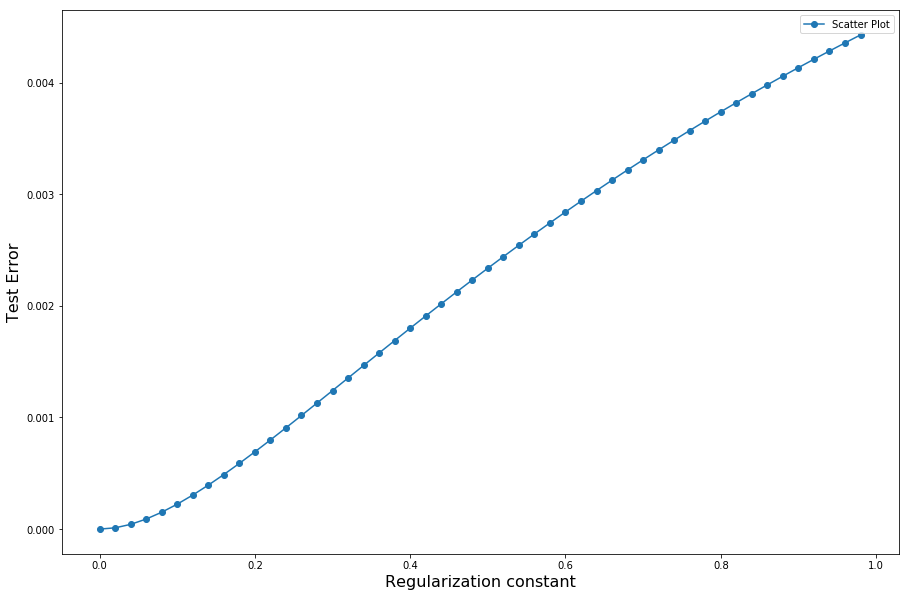

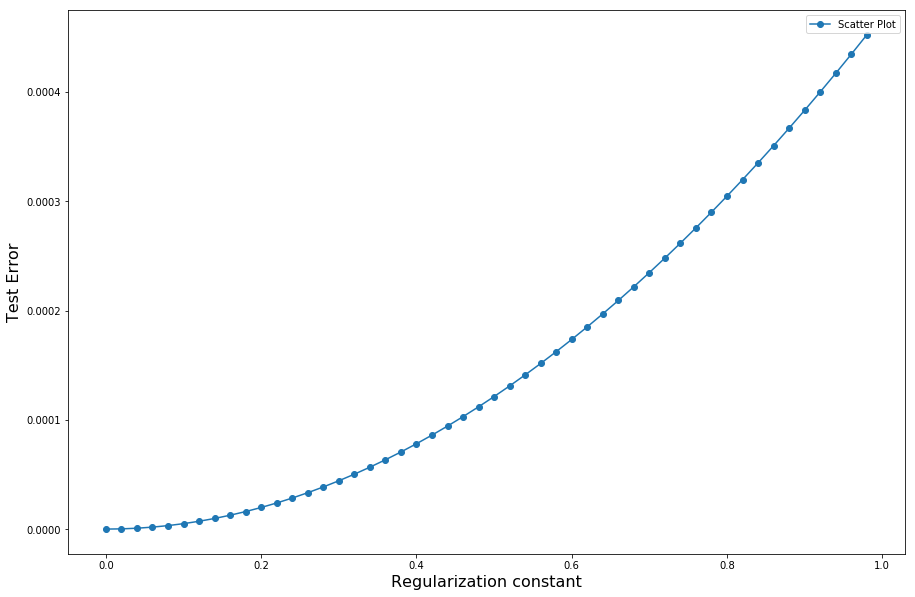

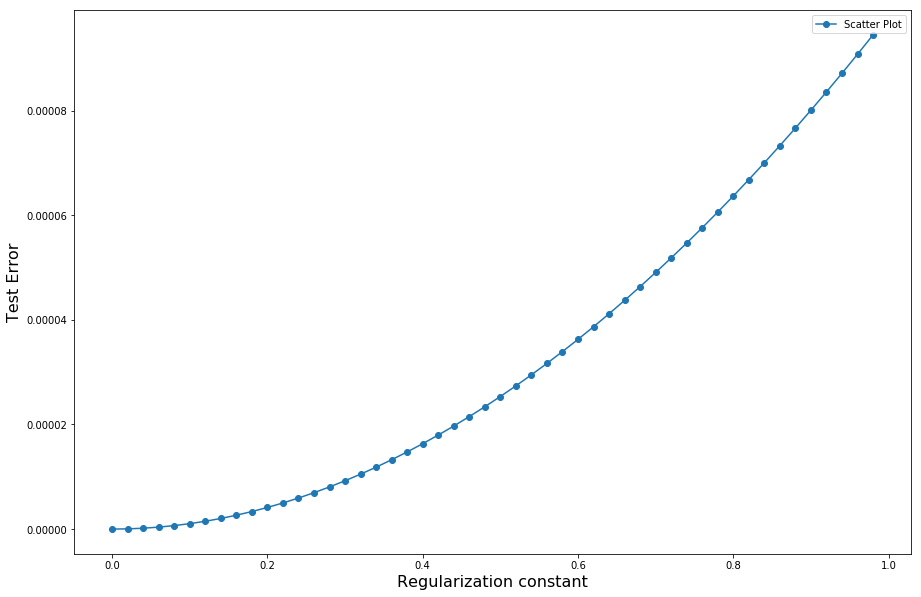

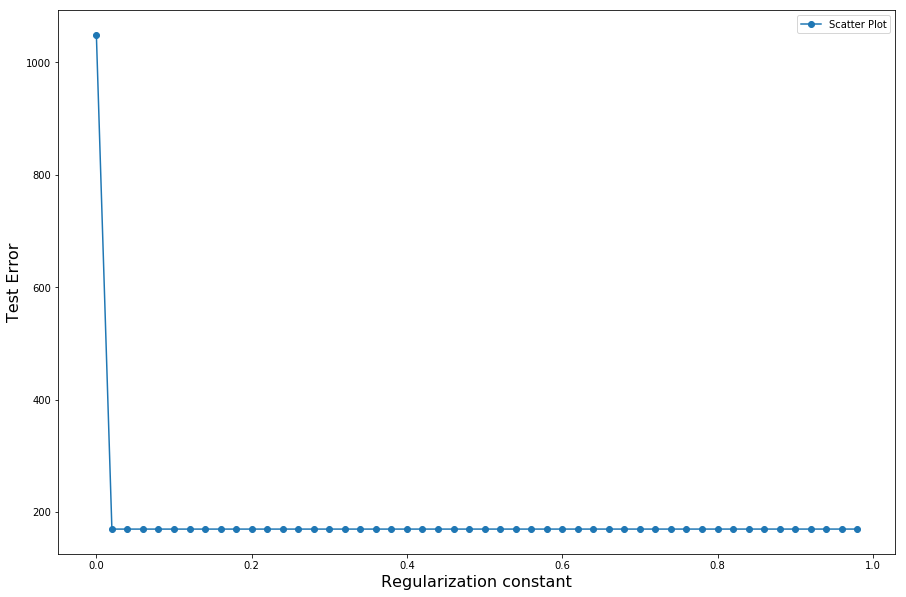

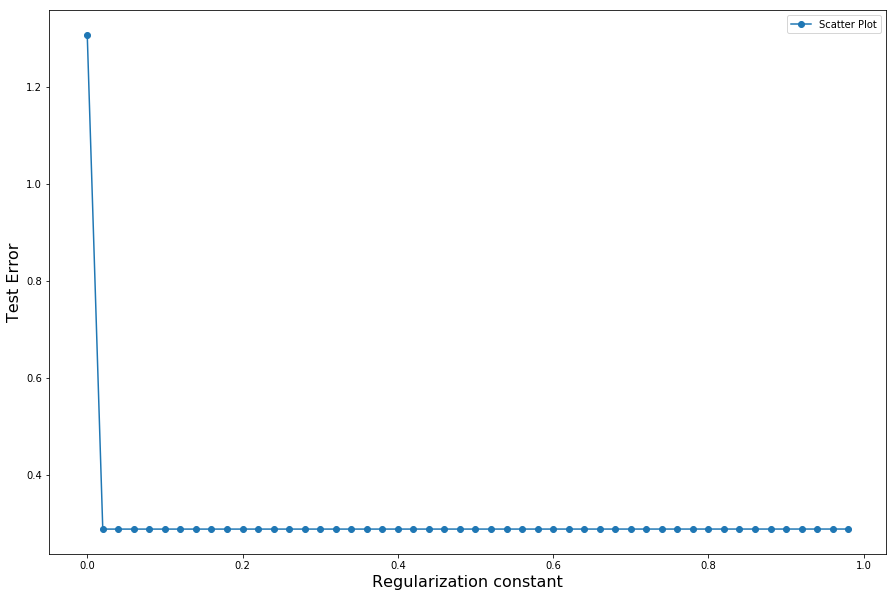

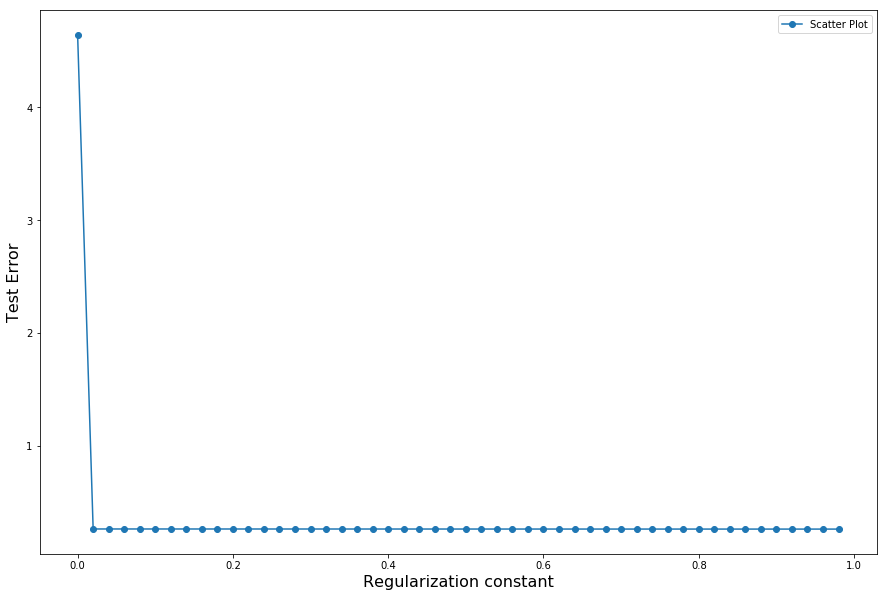

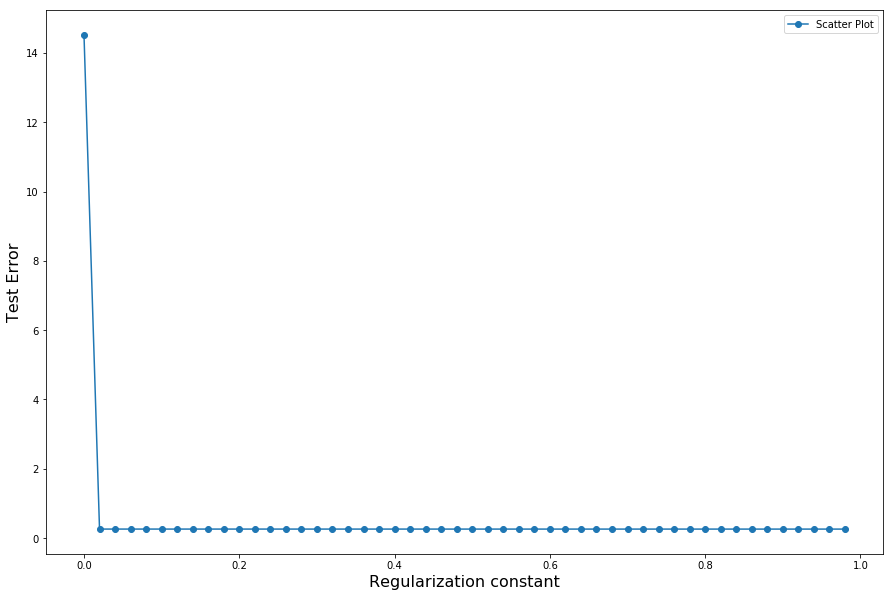

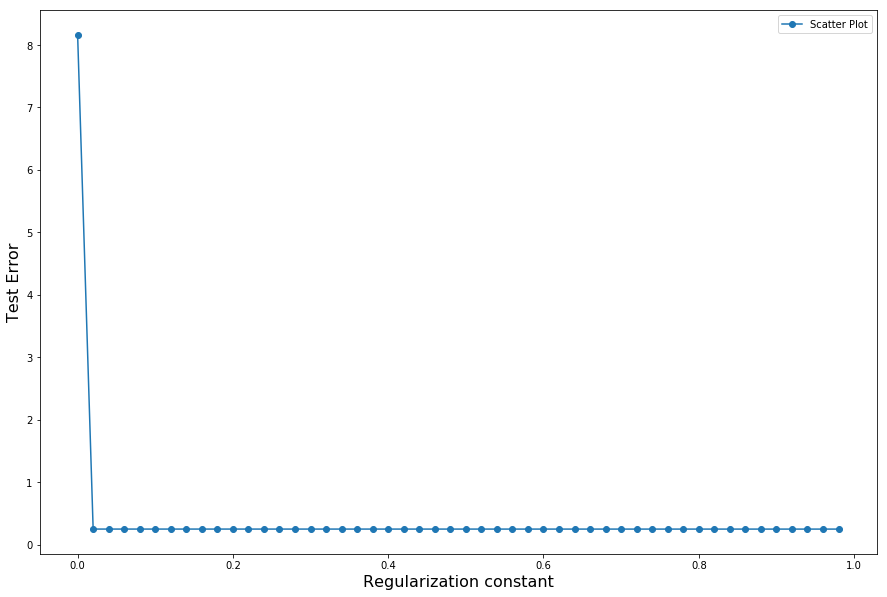

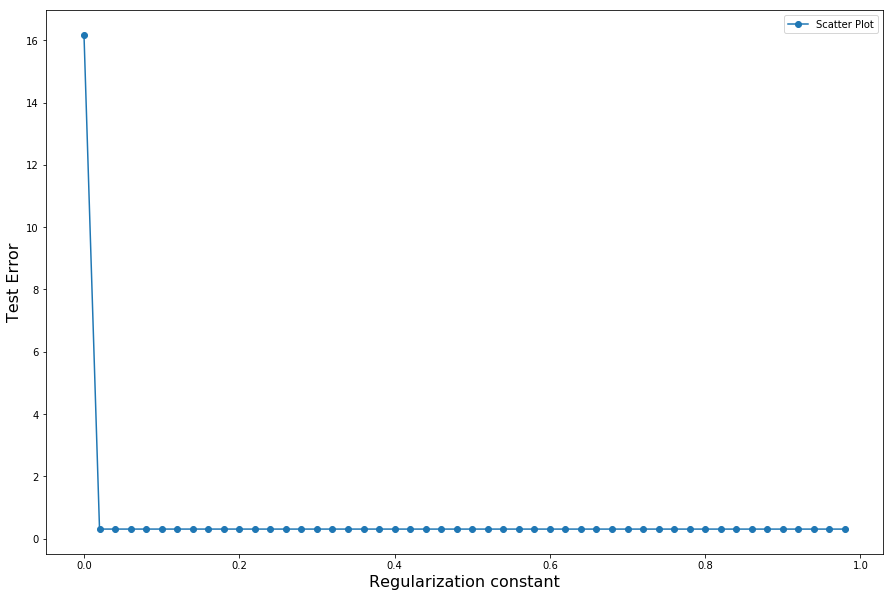

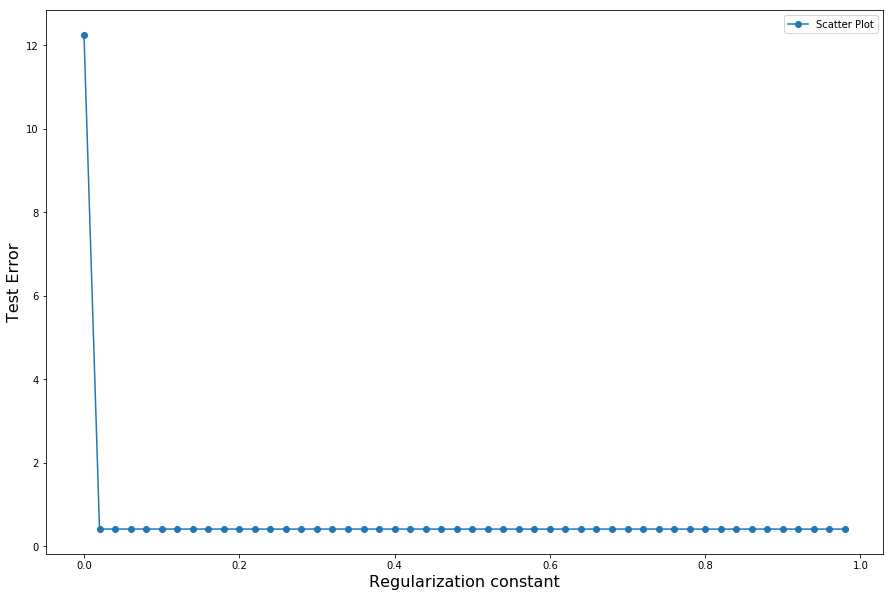

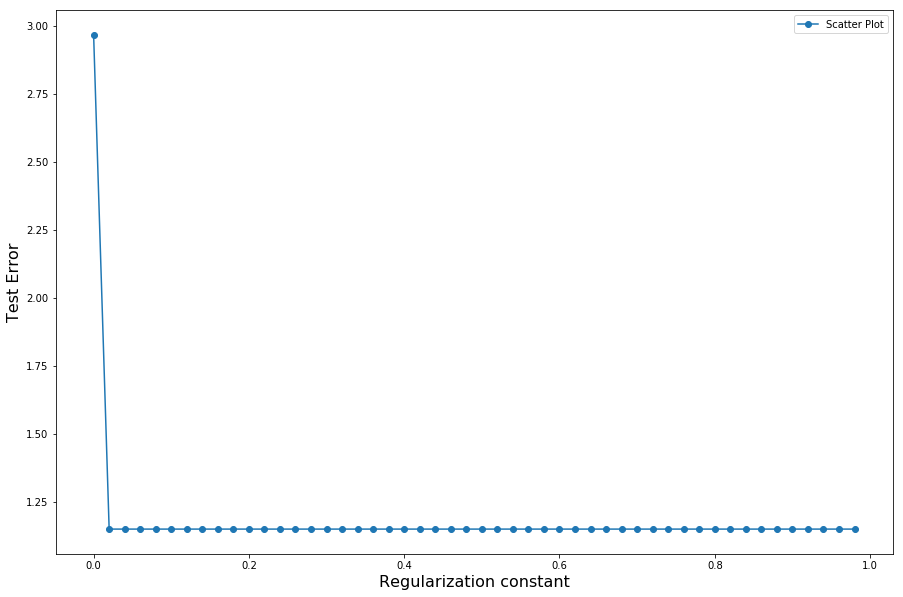

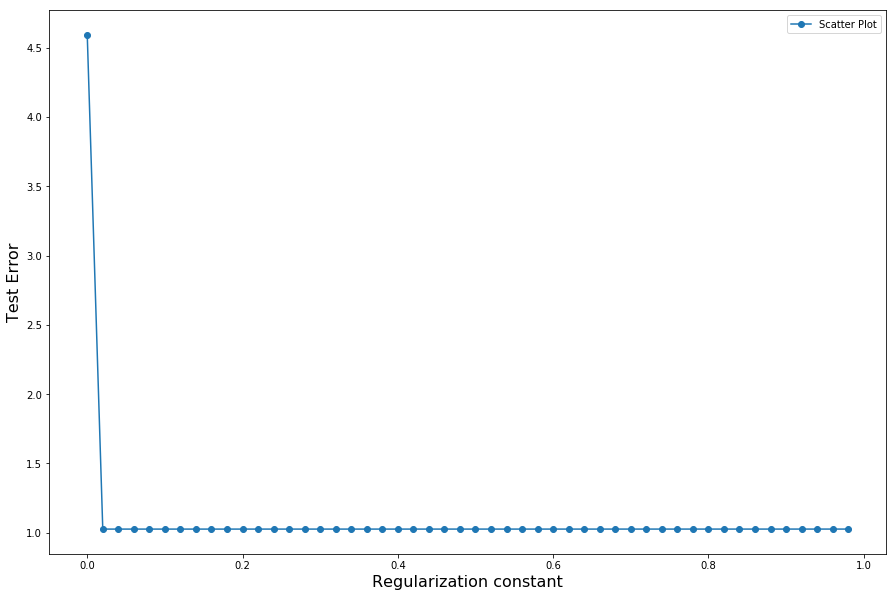

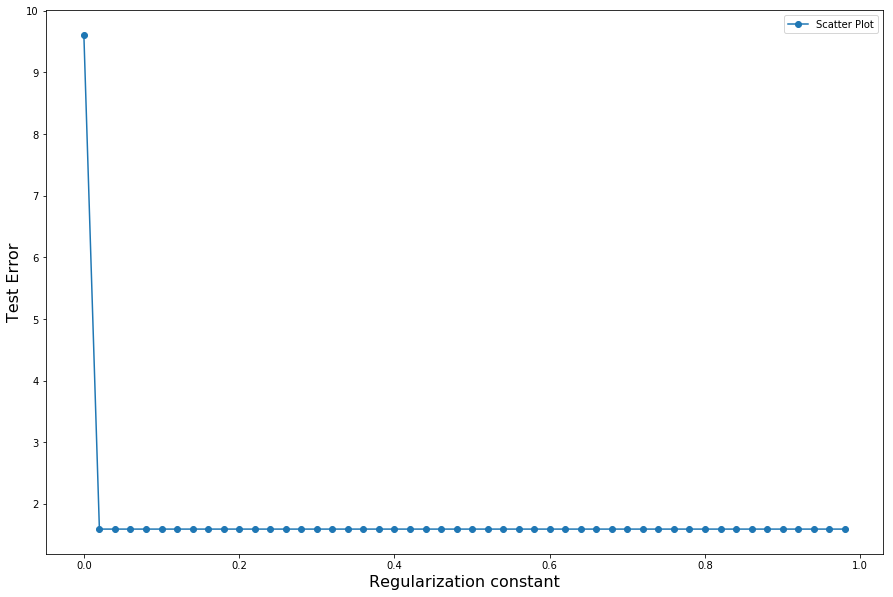

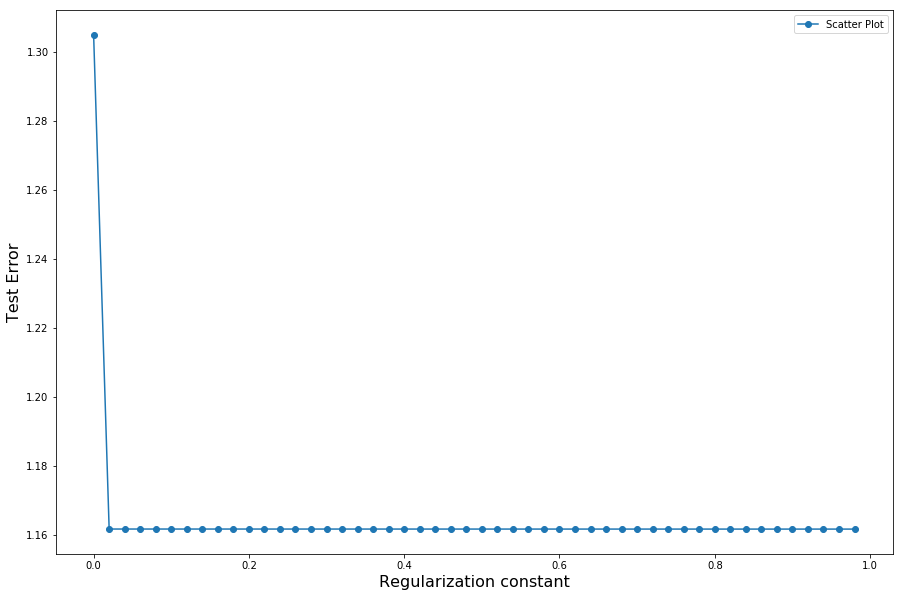

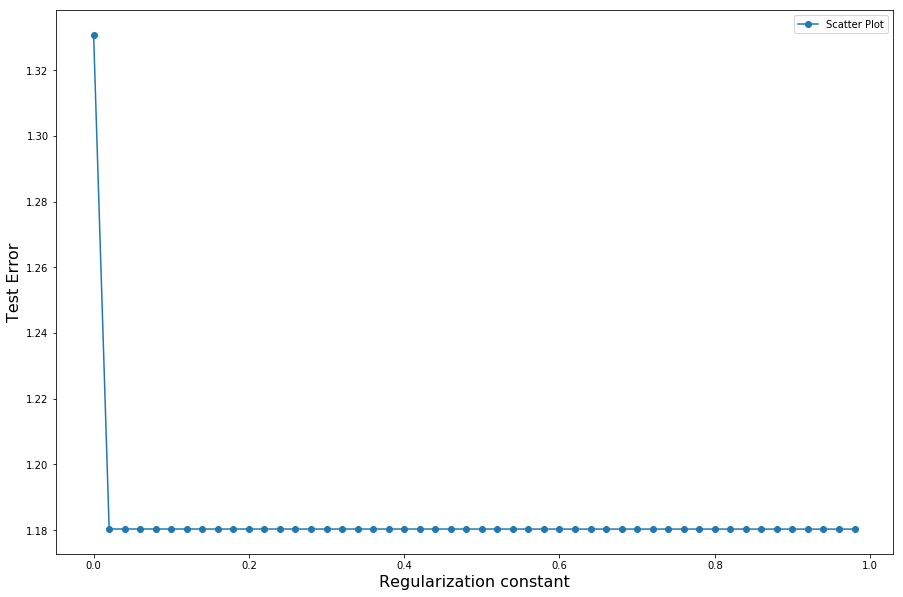

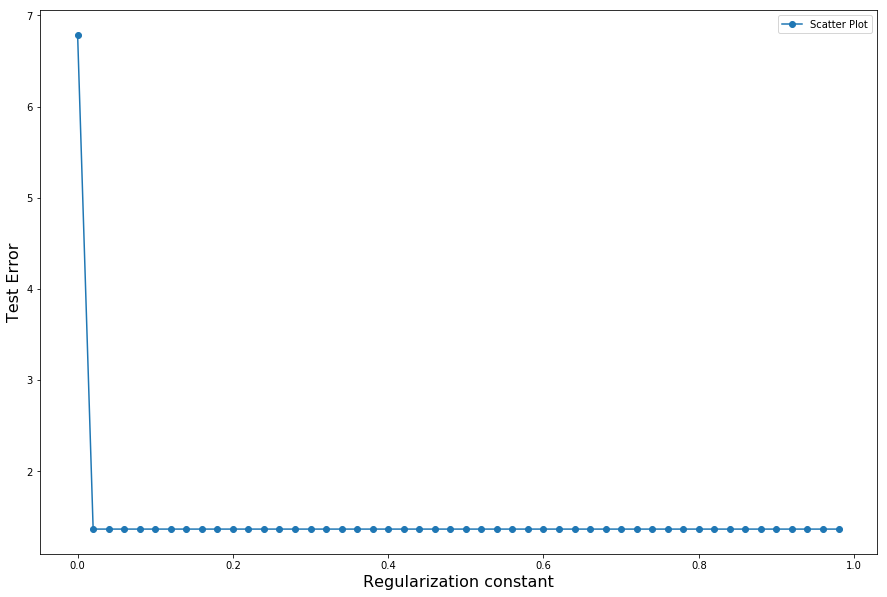

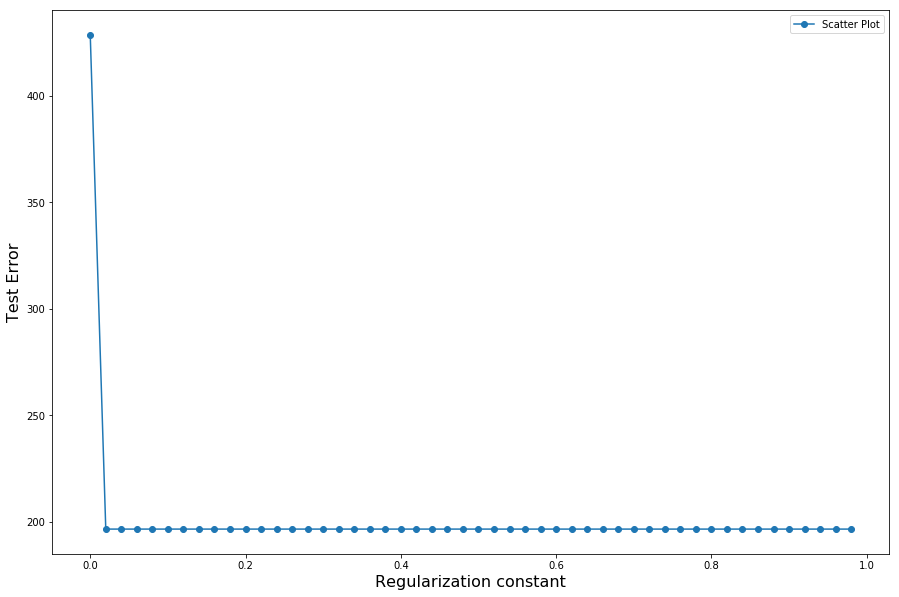

In [183]:
for i in range(len(r2)):
    fig = plt.figure(figsize=(15, 10))
    fig1 = plt.plot(l_iterable, test_errors[i], "-o", label = "Scatter Plot")
    plt.legend()
    plt.xlabel("Regularization constant", fontsize=16)
    plt.ylabel("Test Error", fontsize=16)
    plt.show()

In [184]:
imputed_df = df.copy(deep=True)

### Prediction
After generating the models, and choosing the best model, we use that model to predict 'NaN' in each column.

In [185]:
temp2_df = df.iloc[:, unique_set[set_no]]

for i in range(len(unique_set[set_no])):
    temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
    temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
    temp_data = temp_data.fillna(df.mean())
    missing_values = temp_na_df.iloc[:, i]
    ans = linear_models[i][4].predict(temp_data)
    
    j = 0
    for index in missing_values.index.values:
        missing_values[index] = ans[j]
        j = j + 1
    imputed_df.iloc[:, unique_set[set_no][i]] = \
    imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
    print(missing_values)

598     3.910210
2828    5.979020
2905    5.978086
4470    5.978721
5346    4.208109
Name: IATexpart, dtype: float64
2828    4.553071
2905    4.552600
4470    4.548046
Name: IATexpmath, dtype: float64
2828    4.714894
2905    4.715000
4470    4.715200
Name: IATexp.overall, dtype: float64
909    65.640143
Name: artwarm, dtype: float64
598     5.749379
899     3.939857
1352    7.190378
2828    5.809529
2905    5.703236
3517    6.689467
3582    7.500101
4280    7.159627
4470    5.737853
5346    5.832154
5789    7.166442
5936    7.182859
6071    5.979951
Name: iatexplicitart1, dtype: float64
123     9.412137
141     7.030825
598     5.978360
932     6.527613
976     7.017788
1020    5.197753
1494    4.217011
1764    6.509911
2799    5.599399
2828    5.856894
2880    6.096746
2905    5.859529
2999    8.066902
3020    6.991476
3284    6.811129
3491    6.086686
3508    6.089505
3615    4.419761
3617    7.039224
4163    5.099940
4280    7.084041
4383    6.636802
4470    5.850884
4487    5.4355

### Range of each feature
We just perform a perfunctory check on our predictions with the min-max range of each column valu

In [245]:
for i in range(len(unique_set[set_no])):
    print(df.columns[unique_set[set_no][i]])
    print(max(df.iloc[:, unique_set[set_no][i]]))
    print(min(df.iloc[:, unique_set[set_no][i]]))

IATexpart
7.0
2.0
IATexpmath
7.0
2.0
IATexp.overall
6.6
1.58333333333
artwarm
100.0
0.0
iatexplicitart1
7.0
2.0
iatexplicitart2
7.0
2.0
iatexplicitart3
7.0
2.0
iatexplicitart4
7.0
2.0
iatexplicitart5
7.0
2.0
iatexplicitart6
7.0
2.0
iatexplicitmath1
6.0
1.0
iatexplicitmath2
6.0
1.0
iatexplicitmath3
6.0
1.0
iatexplicitmath4
6.0
1.0
iatexplicitmath5
6.0
1.0
iatexplicitmath6
6.0
1.0
mathwarm
100.0
0.0


In [191]:
# set 82
set_no = 82
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)
    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  1.0
Error on test set is:  3.76815620408e-29

R2 is:  0.999998968517
Error on test set is:  3.60965769662e-13

R2 is:  0.999997937134
Error on test set is:  1.44373591636e-12

R2 is:  0.99999690585
Error on test set is:  3.24811972727e-12

R2 is:  0.999995874667
Error on test set is:  5.77392648691e-12

R2 is:  0.999994843584
Error on test set is:  9.02096569475e-12

R2 is:  0.9999938126
Error on test set is:  1.29890468008e-11

R2 is:  0.999992781716
Error on test set is:  1.76779792494e-11

R2 is:  0.999991750933
Error on test set is:  2.30875727221e-11

R2 is:  0.999990720249
Error on test set is:  2.92176368532e-11

R2 is:  0.999989689665
Error on test set is:  3.60679813883e-11

R2 is:  0.99998865918
Error on test set is:  4.36384160872e-11

R2 is:  0.999987628796
Error on test set is:  5.1928750773e-11

R2 is:  0.999986598511
Error on test set is:  6.09387954794e-11

R2 is:  0.999985568326
Error on test set is:  7.06683597954e-11

R2 is:  0.999984538241
Error on test set 

R2 is:  0.995207002479
Error on test set is:  3.79907394994e-05

R2 is:  0.995058108895
Error on test set is:  4.03925264217e-05

R2 is:  0.994909268811
Error on test set is:  4.28673199108e-05

R2 is:  0.994760482201
Error on test set is:  4.54150670017e-05

R2 is:  0.994611749038
Error on test set is:  4.80357147659e-05

R2 is:  0.994463069297
Error on test set is:  5.07292103103e-05

R2 is:  0.994314442952
Error on test set is:  5.34955007864e-05

R2 is:  0.994165869978
Error on test set is:  5.6334533379e-05

R2 is:  0.994017350348
Error on test set is:  5.92462553129e-05

R2 is:  0.993868884037
Error on test set is:  6.22306138506e-05

R2 is:  0.99372047102
Error on test set is:  6.52875562926e-05

R2 is:  0.99357211127
Error on test set is:  6.84170299797e-05

R2 is:  0.993423804762
Error on test set is:  7.16189822876e-05

R2 is:  0.99327555147
Error on test set is:  7.48933606325e-05

R2 is:  0.993127351369
Error on test set is:  7.82401124664e-05

R2 is:  0.992979204433
Error 

R2 is:  0.994300454771
Error on test set is:  1.94144700519e-05

R2 is:  0.994042789487
Error on test set is:  2.12129608416e-05

R2 is:  0.993785245764
Error on test set is:  2.30905120281e-05

R2 is:  0.993527823525
Error on test set is:  2.50470499154e-05

R2 is:  0.993270522694
Error on test set is:  2.70825008801e-05

R2 is:  0.993013343196
Error on test set is:  2.91967913687e-05

R2 is:  0.992756284956
Error on test set is:  3.13898478956e-05

R2 is:  0.992499347897
Error on test set is:  3.36615970476e-05

R2 is:  0.992242531943
Error on test set is:  3.60119654779e-05

R2 is:  0.99198583702
Error on test set is:  3.84408799127e-05

R2 is:  0.991729263052
Error on test set is:  4.09482671452e-05

R2 is:  0.991472809964
Error on test set is:  4.35340540402e-05

R2 is:  0.99121647768
Error on test set is:  4.61981675295e-05

R2 is:  0.990960266125
Error on test set is:  4.89405346155e-05

R2 is:  0.990704175224
Error on test set is:  5.1761082372e-05

R2 is:  0.990448204901
Error

R2 is:  0.997085193724
Error on test set is:  5.83964346732e-06

R2 is:  0.996843049923
Error on test set is:  6.85126888135e-06

R2 is:  0.996601022193
Error on test set is:  7.94329823629e-06

R2 is:  0.996359110462
Error on test set is:  9.115653922e-06

R2 is:  0.996117314654
Error on test set is:  1.03682584021e-05

R2 is:  0.995875634696
Error on test set is:  1.17010342174e-05

R2 is:  0.995634070514
Error on test set is:  1.31139039842e-05

R2 is:  0.995392622035
Error on test set is:  1.46067903927e-05

R2 is:  0.995151289184
Error on test set is:  1.61796162105e-05

R2 is:  0.994910071888
Error on test set is:  1.78323042787e-05

R2 is:  0.994668970073
Error on test set is:  1.95647775147e-05

R2 is:  0.994427983665
Error on test set is:  2.137695891e-05

R2 is:  0.994187112592
Error on test set is:  2.32687715327e-05

R2 is:  0.993946356778
Error on test set is:  2.52401385245e-05

R2 is:  0.993705716152
Error on test set is:  2.72909831018e-05

R2 is:  0.99346519064
Error o

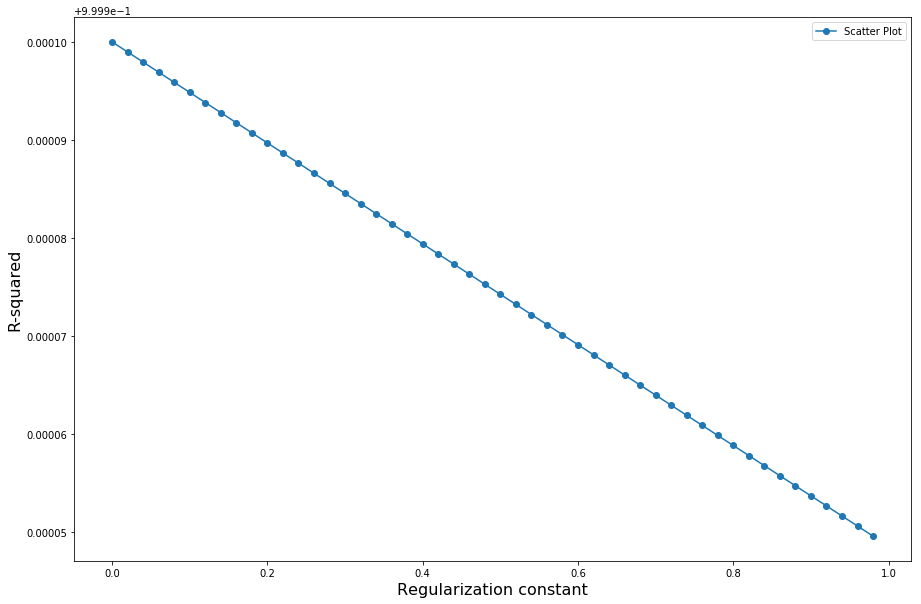

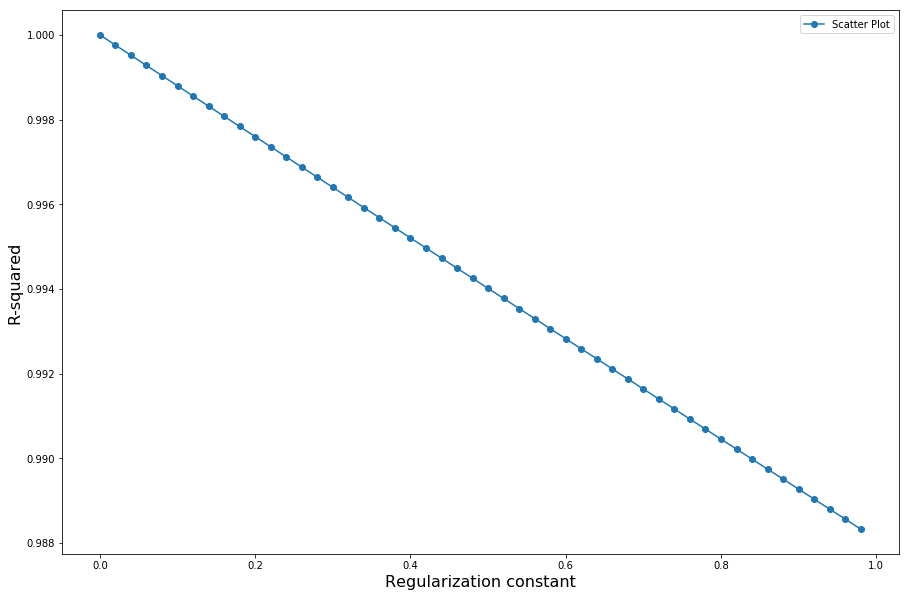

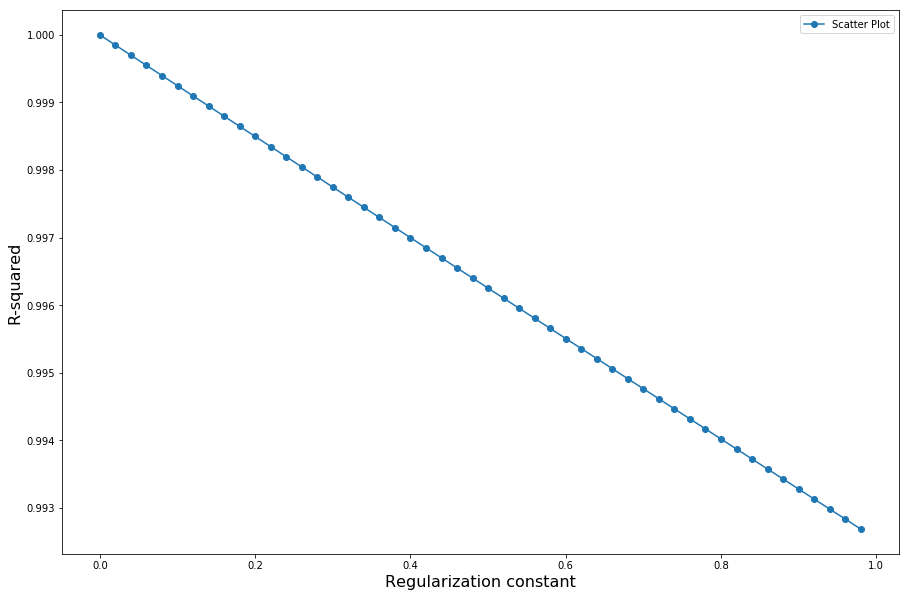

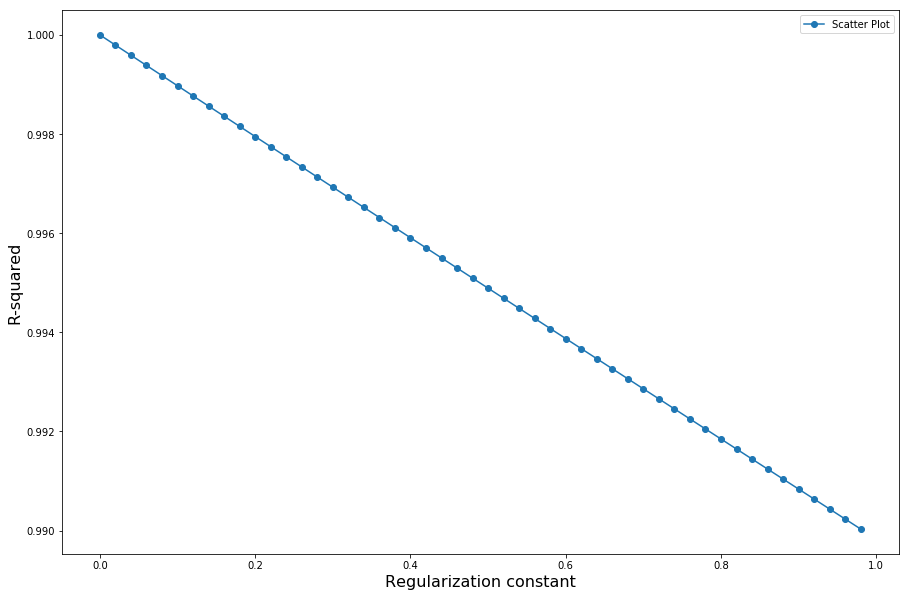

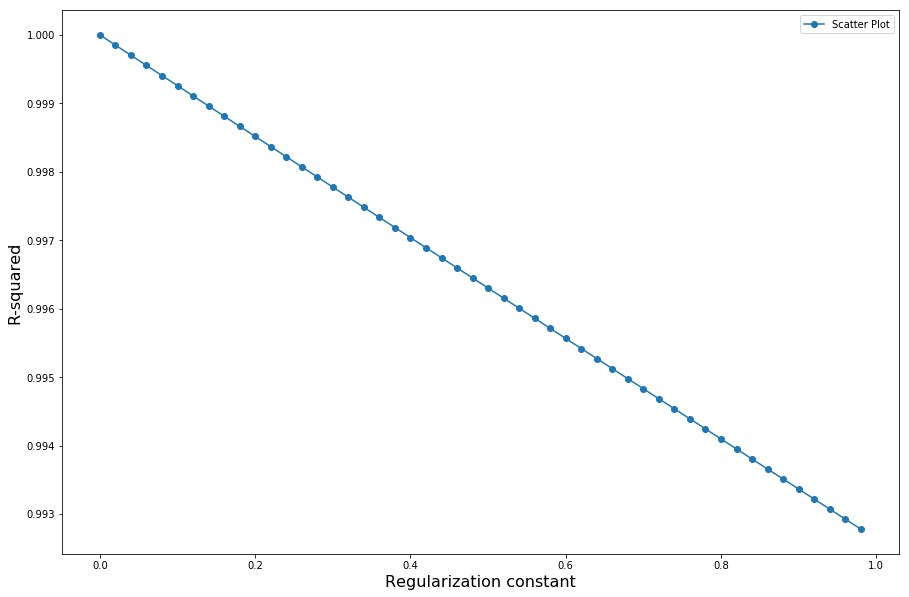

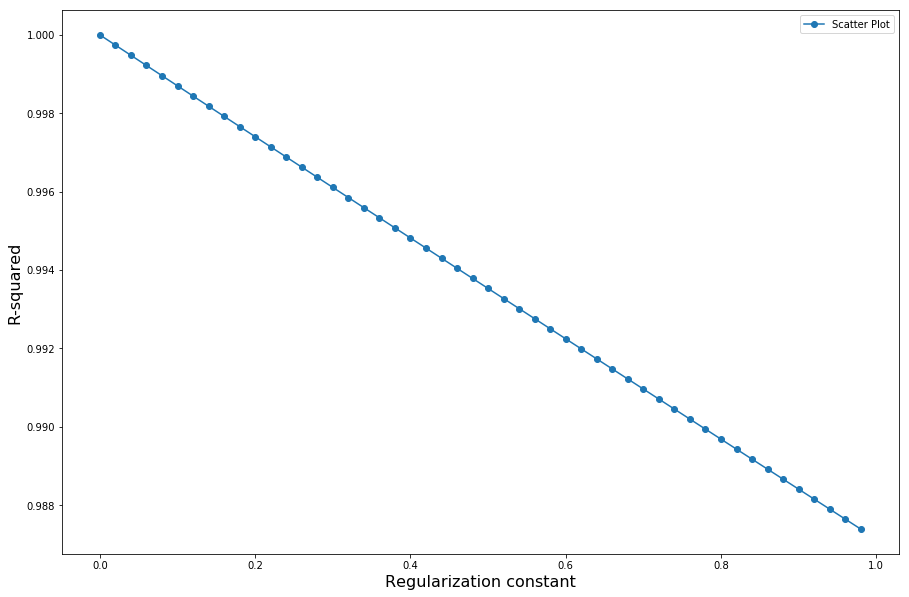

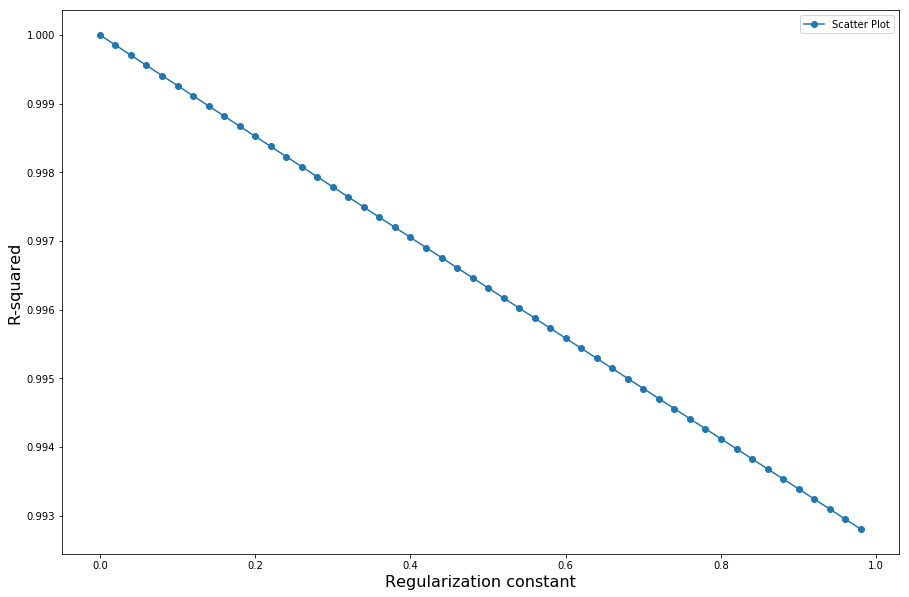

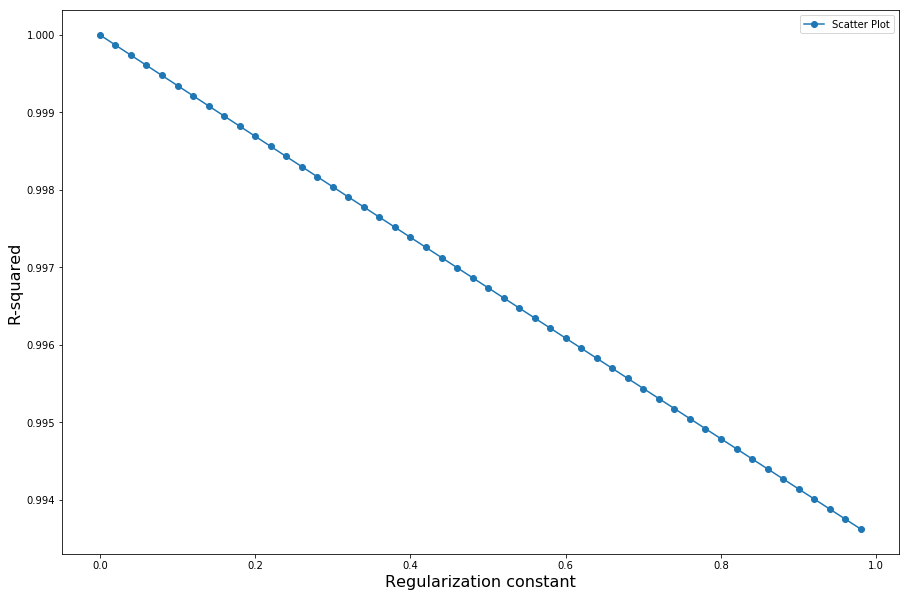

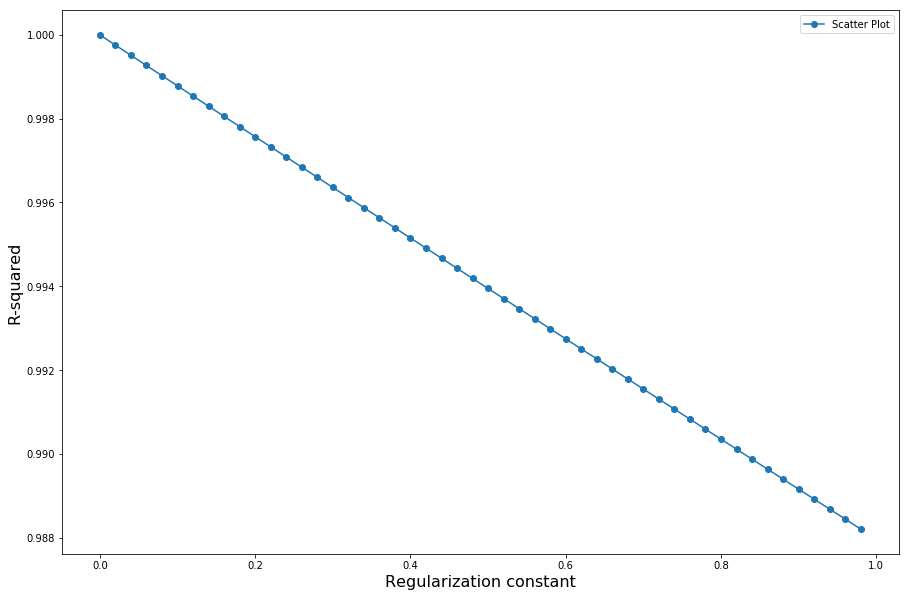

In [192]:
for i in range(len(r2)):
    fig = plt.figure(figsize=(15, 10))
    fig1 = plt.plot(l_iterable, r2[i], "-o", label = "Scatter Plot")
    plt.legend()
    plt.xlabel("Regularization constant", fontsize=16)
    plt.ylabel("R-squared", fontsize=16)
    plt.show()

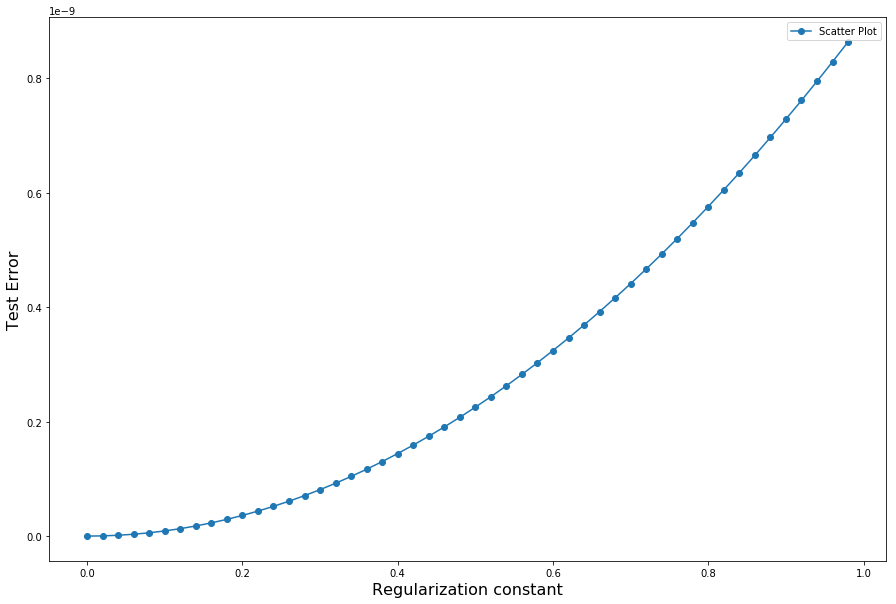

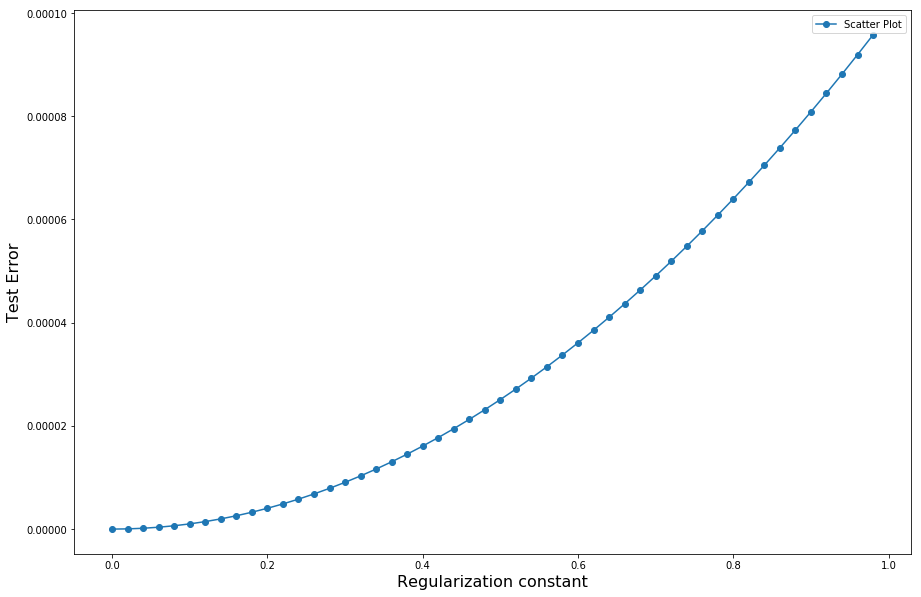

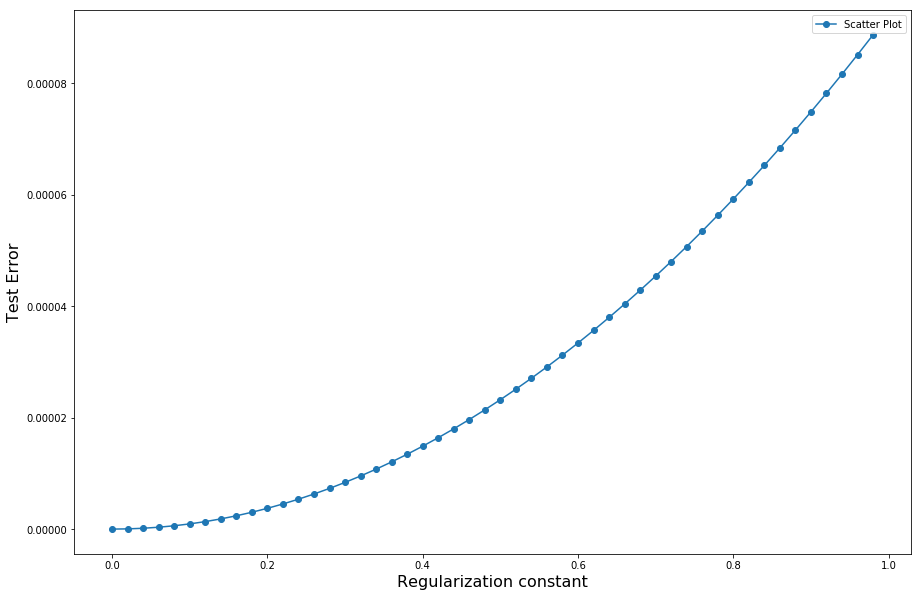

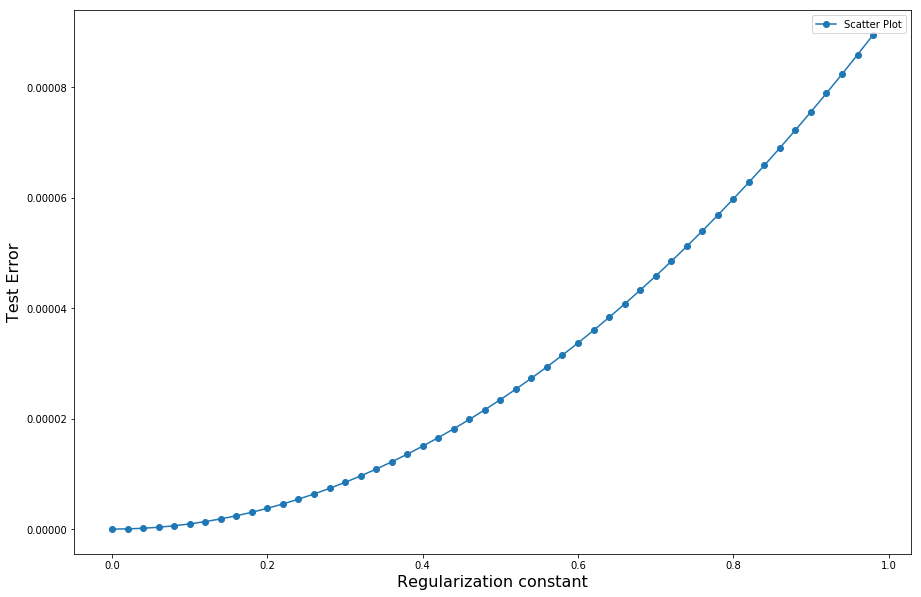

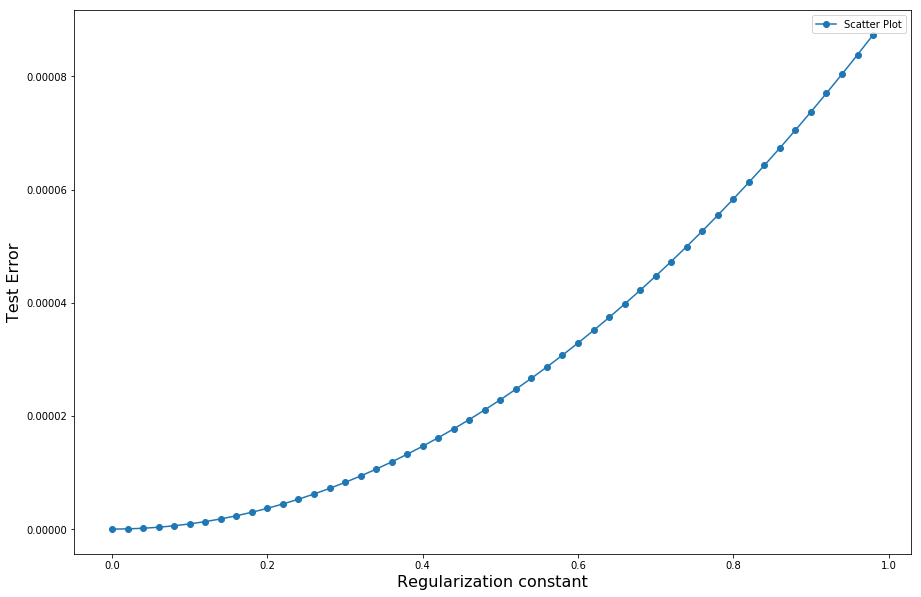

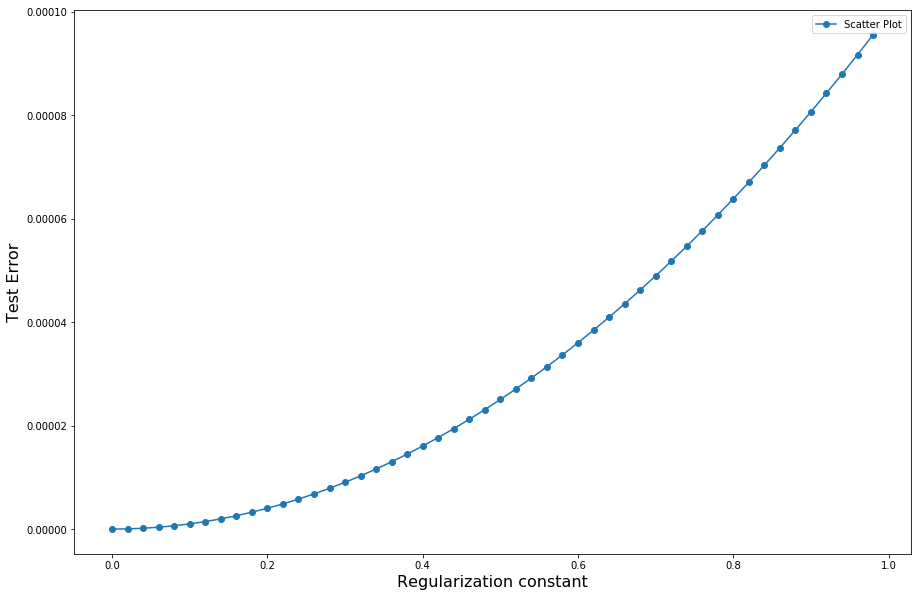

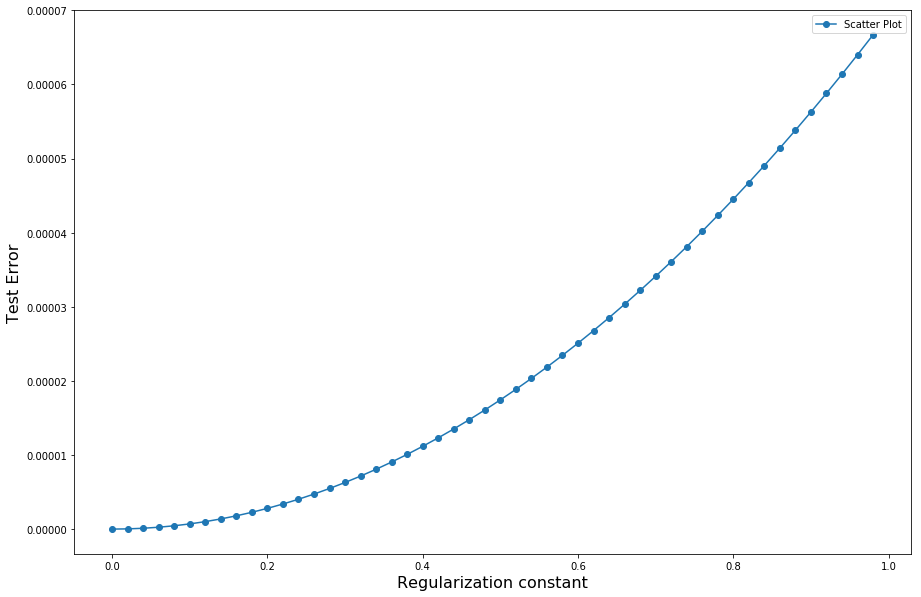

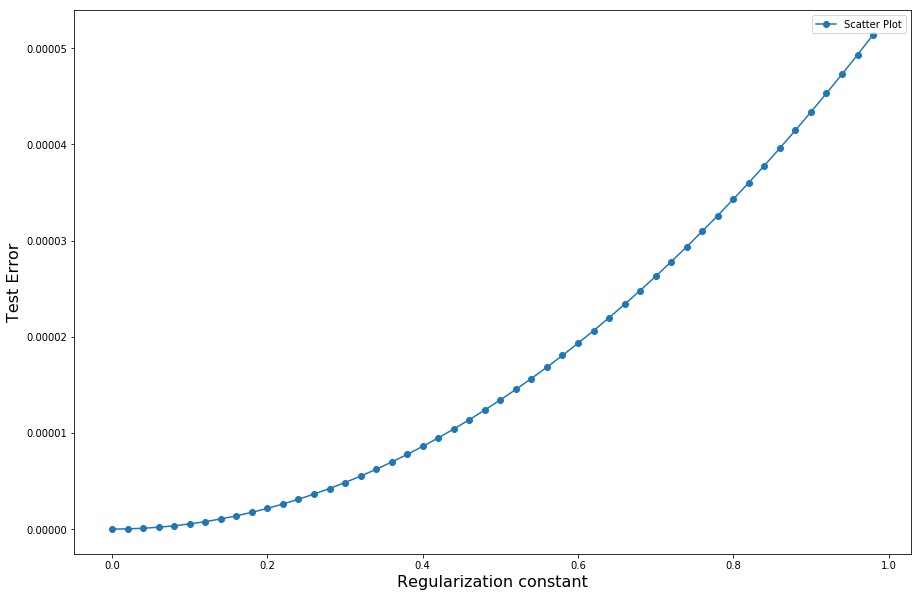

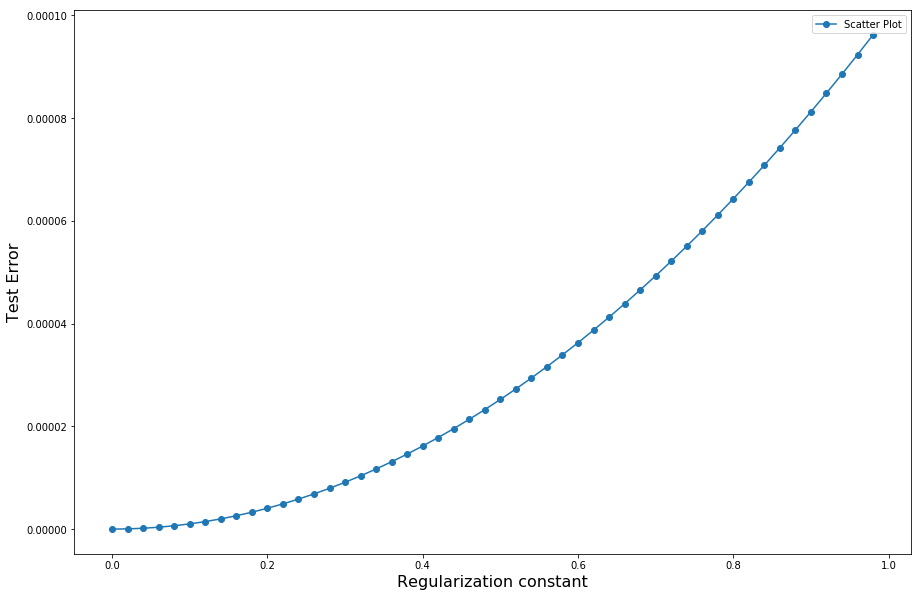

In [193]:
for i in range(len(r2)):
    fig = plt.figure(figsize=(15, 10))
    fig1 = plt.plot(l_iterable, test_errors[i], "-o", label = "Scatter Plot")
    plt.legend()
    plt.xlabel("Regularization constant", fontsize=16)
    plt.ylabel("Test Error", fontsize=16)
    plt.show()

In [194]:
temp2_df = df.iloc[:, unique_set[set_no]]

for i in range(len(unique_set[set_no])):
    temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
    temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
    temp_data = temp_data.fillna(df.mean())
    missing_values = temp_na_df.iloc[:, i]
    ans = linear_models[i][4].predict(temp_data)
    
    j = 0
    for index in missing_values.index.values:
        missing_values[index] = ans[j]
        j = j + 1
    imputed_df.iloc[:, unique_set[set_no][i]] = \
    imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
    print(missing_values)

2828    3.092719
4470    3.092719
5390    3.092719
Name: flagdv, dtype: float64
77       2.714443
426      3.571315
455      5.942652
921      3.000182
1009     2.428717
1016     3.142832
1453     3.428380
1785     3.856850
1818     2.123093
1855     3.714147
1885    10.119610
2133     4.713923
2161     3.999969
2182     2.000319
2329     5.121846
2352     4.856577
2450     2.571612
2503     3.142844
2523     1.022215
2828     3.038511
2884     2.143167
3262     2.456247
3711     1.286089
4088     2.571585
4296     3.285483
4343     5.423767
4470     3.038511
5142     1.986700
5288     3.999775
5390     3.038511
5605     4.713782
5944     9.982495
Name: flagdv1, dtype: float64
300      4.832220
455      5.441920
537      2.570748
620      2.428310
789      2.105109
821      3.142368
960      1.999504
1358     3.428781
1494     4.427776
1717     3.999880
1818     1.621817
1885     9.619516
1967     1.857194
2224     4.477151
2329     4.621077
2716     2.771956
2748     4.714502
2828    

In [196]:
for i in range(len(unique_set[set_no])):
    print(df.columns[unique_set[set_no][i]])
    print(max(df.iloc[:, unique_set[set_no][i]]))
    print(min(df.iloc[:, unique_set[set_no][i]]))
    print()

flagdv
6.875
1.0

flagdv1
7.0
1.0

flagdv2
7.0
1.0

flagdv3
7.0
1.0

flagdv4
7.0
1.0

flagdv5
7.0
1.0

flagdv6
7.0
1.0

flagdv7
7.0
1.0

flagdv8
7.0
1.0



In [198]:
for set_no in unique_set.keys():
    if set_no == 137 or set_no == 110 or set_no == 82 or len(unique_set[set_no]) == 1:
        continue
    temp_data = df.iloc[:, unique_set[set_no]].dropna()
    num_training_instances = int(0.8 * temp_data.shape[0])
    num_test_instances = int(0.9 * temp_data.shape[0])
    temp_data.sample(frac=1, axis=0, random_state=5)
    training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                           num_training_instances:num_test_instances,
                                                                           :], temp_data.iloc[num_test_instances:, :]
    linear_models = []
    r2 = []
    test_errors = []
    l_iterable = [i*0.02 for i in range(50)]
    for i in range(len(unique_set[set_no])):
        temp_models = []
        temp_r2 = []
        temp_test_errors = []
        for l in l_iterable:
            linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                            labels=training.iloc[:, i])
    #         linear_model.train(type_="lasso", l=l, iterations=100)
            linear_model.train(type_="ridge", l=l, verbose=False)
            rsquared = linear_model.compute_rsquared()
            print("R2 is: ", rsquared)
            temp_r2.append(rsquared)
            error = linear_model.test(test_data=test.iloc\
                      [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                      test.iloc[:, i])
            temp_test_errors.append(error)
            print("Error on test set is: ", error)
            print()
            temp_models.append(linear_model)
        linear_models.append(temp_models)
        r2.append(temp_r2)
        test_errors.append(temp_test_errors)
        
    temp2_df = df.iloc[:, unique_set[set_no]]

    for i in range(len(unique_set[set_no])):
        temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
        temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
        temp_data = temp_data.fillna(df.mean())
        missing_values = temp_na_df.iloc[:, i]
        ans = linear_models[i][4].predict(temp_data)

        j = 0
        for index in missing_values.index.values:
            missing_values[index] = ans[j]
            j = j + 1
        imputed_df.iloc[:, unique_set[set_no][i]] = \
        imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
        print(missing_values)  

ValueError: a must be greater than 0

In [200]:
# set 140
set_no = 140
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)
    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.546382280835
Error on test set is:  0.45293730149

R2 is:  0.546364013842
Error on test set is:  0.452940638649

R2 is:  0.546345747948
Error on test set is:  0.452943976692

R2 is:  0.546327483152
Error on test set is:  0.452947315618

R2 is:  0.546309219454
Error on test set is:  0.452950655426

R2 is:  0.546290956856
Error on test set is:  0.452953996118

R2 is:  0.546272695356
Error on test set is:  0.452957337692

R2 is:  0.546254434954
Error on test set is:  0.45296068015

R2 is:  0.546236175651
Error on test set is:  0.45296402349

R2 is:  0.546217917447
Error on test set is:  0.452967367714

R2 is:  0.546199660341
Error on test set is:  0.45297071282

R2 is:  0.546181404333
Error on test set is:  0.452974058809

R2 is:  0.546163149424
Error on test set is:  0.45297740568

R2 is:  0.546144895613
Error on test set is:  0.452980753435

R2 is:  0.5461266429
Error on test set is:  0.452984102072

R2 is:  0.546108391285
Error on test set is:  0.452987451592

R2 is:  0.54609

R2 is:  0.15206580865
Error on test set is:  32609654783.7

R2 is:  0.152055839401
Error on test set is:  32609330930.4

R2 is:  0.152045875407
Error on test set is:  32609007310.8

R2 is:  0.152035916664
Error on test set is:  32608683924.7

R2 is:  0.152025963169
Error on test set is:  32608360772.1

R2 is:  0.152016014919
Error on test set is:  32608037852.6

R2 is:  0.152006071909
Error on test set is:  32607715166.2

R2 is:  0.151996134137
Error on test set is:  32607392712.6

R2 is:  0.151986201599
Error on test set is:  32607070491.7

R2 is:  0.151976274291
Error on test set is:  32606748503.3

R2 is:  0.151966352211
Error on test set is:  32606426747.2

R2 is:  0.151956435354
Error on test set is:  32606105223.3

R2 is:  0.151946523717
Error on test set is:  32605783931.4

R2 is:  0.151936617297
Error on test set is:  32605462871.3

R2 is:  0.151926716089
Error on test set is:  32605142042.9

R2 is:  0.151916820092
Error on test set is:  32604821445.9

R2 is:  0.151906929301
Er

R2 is:  0.332161389192
Error on test set is:  76242272547.0

R2 is:  0.332156063484
Error on test set is:  76242483921.1

R2 is:  0.332150741032
Error on test set is:  76242695439.0

R2 is:  0.332145421836
Error on test set is:  76242907100.4

R2 is:  0.332140105892
Error on test set is:  76243118905.2

R2 is:  0.332134793199
Error on test set is:  76243330853.3

R2 is:  0.332129483754
Error on test set is:  76243542944.5

R2 is:  0.332124177554
Error on test set is:  76243755178.6

R2 is:  0.332118874598
Error on test set is:  76243967555.4

R2 is:  0.332113574883
Error on test set is:  76244180074.8

R2 is:  0.332108278407
Error on test set is:  76244392736.6

R2 is:  0.332102985167
Error on test set is:  76244605540.7

R2 is:  0.332097695162
Error on test set is:  76244818486.8

R2 is:  0.332092408389
Error on test set is:  76245031574.8

R2 is:  0.332087124846
Error on test set is:  76245244804.6

R2 is:  0.33208184453
Error on test set is:  76245458175.9

R2 is:  0.332076567439
Er

In [201]:
temp2_df = df.iloc[:, unique_set[set_no]]

for i in range(len(unique_set[set_no])):
    temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
    temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
    temp_data = temp_data.fillna(df.mean())
    missing_values = temp_na_df.iloc[:, i]
    ans = linear_models[i][4].predict(temp_data)
    
    j = 0
    for index in missing_values.index.values:
        missing_values[index] = ans[j]
        j = j + 1
    imputed_df.iloc[:, unique_set[set_no][i]] = \
    imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
    print(missing_values)

1480    3.578308
2370    3.749659
2828    3.578308
3129    3.578308
3945    3.578308
4232    3.637415
4333    3.578308
4470    3.578308
5680    2.647432
5704    3.633298
5959    3.578308
Name: Sysjust, dtype: float64
135     467149.724321
564      93312.361324
858     480281.069691
1480    134504.553443
1489    341182.265070
1925     62094.869075
1944     84703.091330
2032    235424.902071
2093    -44890.023855
2189   -117971.010577
2403    202927.536690
2410     73349.628373
2520     85333.388079
2828    134504.553443
3129    134504.553443
3189    488085.712501
3945    134504.553443
4262    142420.607138
4333    134504.553443
4470    134504.553443
5115     19075.156260
5621    -55198.902416
5959    134504.553443
Name: sysjust1, dtype: float64
433     164878.150956
436    -170874.408389
564     199114.838612
568     289422.212103
791       7049.187522
877     273589.480167
1188    158236.257061
1480    197757.362982
1965    300482.294159
1977     96637.644699
2006    138133.492899
2065

In [211]:
set_no = 107
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)
    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  1.0
Error on test set is:  1.63441728121e-29

R2 is:  0.999999485245
Error on test set is:  2.58910091e-13

R2 is:  0.999998970515
Error on test set is:  1.03558581993e-12

R2 is:  0.999998455811
Error on test set is:  2.3299453942e-12

R2 is:  0.999997941131
Error on test set is:  4.14190700494e-12

R2 is:  0.999997426477
Error on test set is:  6.47138902006e-12

R2 is:  0.999996911849
Error on test set is:  9.31830940284e-12

R2 is:  0.999996397245
Error on test set is:  1.268258679e-11

R2 is:  0.999995882667
Error on test set is:  1.65641392555e-11

R2 is:  0.999995368114
Error on test set is:  2.09628851869e-11

R2 is:  0.999994853587
Error on test set is:  2.58787426862e-11

R2 is:  0.999994339084
Error on test set is:  3.13116302891e-11

R2 is:  0.999993824607
Error on test set is:  3.7261466249e-11

R2 is:  0.999993310156
Error on test set is:  4.37281689128e-11

R2 is:  0.999992795729
Error on test set is:  5.07116566941e-11

R2 is:  0.999992281328
Error on test set is

R2 is:  0.999166415933
Error on test set is:  2.49372354214e-06

R2 is:  0.999138679636
Error on test set is:  2.66255762913e-06

R2 is:  0.999110946549
Error on test set is:  2.8369090956e-06

R2 is:  0.999083216673
Error on test set is:  3.01677679035e-06

R2 is:  0.999055490006
Error on test set is:  3.20215956325e-06

R2 is:  0.999027766547
Error on test set is:  3.39305626407e-06

R2 is:  0.999000046298
Error on test set is:  3.58946574258e-06

R2 is:  0.998972329256
Error on test set is:  3.79138684915e-06

R2 is:  0.998944615422
Error on test set is:  3.99881843458e-06

R2 is:  0.998916904795
Error on test set is:  4.2117593492e-06

R2 is:  0.998889197375
Error on test set is:  4.43020844419e-06

R2 is:  0.998861493161
Error on test set is:  4.6541645711e-06

R2 is:  0.998833792152
Error on test set is:  4.8836265807e-06

R2 is:  0.998806094349
Error on test set is:  5.11859332547e-06

R2 is:  0.998778399751
Error on test set is:  5.35906365734e-06

R2 is:  0.998750708357
Error 

In [212]:
temp2_df = df.iloc[:, unique_set[set_no]]

for i in range(len(unique_set[set_no])):
    temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
    temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
    temp_data = temp_data.fillna(df.mean())
    missing_values = temp_na_df.iloc[:, i]
    ans = linear_models[i][4].predict(temp_data)
    
    j = 0
    for index in missing_values.index.values:
        missing_values[index] = ans[j]
        j = j + 1
    imputed_df.iloc[:, unique_set[set_no][i]] = \
    imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
    print(missing_values)

2828    4.707902
3040    4.707902
4333    4.707902
4354    4.707902
4470    4.707902
4809    4.707902
5726    4.707902
5872    4.707902
Name: Imagineddv, dtype: float64
595     1.666753
734     3.791702
1556    2.791795
1581    6.999870
1618    6.333194
2828    4.874419
2867    7.791206
3040    4.874419
4078    3.164779
4156    2.666834
4177    8.791113
4333    4.874419
4354    4.874419
4470    4.874419
4809    4.874419
4837    8.791113
4858    5.333365
4886    7.999920
5588    5.999996
5726    4.874419
5872    4.874419
Name: imaginedexplicit1, dtype: float64
2828    3.834985
3040    3.834985
3293    3.999898
4016    2.999922
4078    2.125383
4333    3.834985
4354    3.834985
4470    3.834985
4809    3.834985
5726    3.834985
5872    3.834985
Name: imaginedexplicit2, dtype: float64
206     6.000008
734     4.125397
756     2.087199
1157    9.000023
1351    1.666786
1377    4.999936
1556    3.125493
2828    5.208116
2867    8.124991
3040    5.208116
4177    9.124895
4333    5.208116
434

In [217]:
set_no = 118
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.332793172339
Error on test set is:  0.769646752319

R2 is:  0.332697635146
Error on test set is:  0.769626172197

R2 is:  0.332602125848
Error on test set is:  0.769605618321

R2 is:  0.332506644441
Error on test set is:  0.769585090687

R2 is:  0.332411190921
Error on test set is:  0.769564589294

R2 is:  0.332315765286
Error on test set is:  0.769544114136

R2 is:  0.332220367532
Error on test set is:  0.769523665211

R2 is:  0.332124997656
Error on test set is:  0.769503242516

R2 is:  0.332029655655
Error on test set is:  0.769482846047

R2 is:  0.331934341525
Error on test set is:  0.769462475802

R2 is:  0.331839055263
Error on test set is:  0.769442131776

R2 is:  0.331743796866
Error on test set is:  0.769421813967

R2 is:  0.33164856633
Error on test set is:  0.769401522371

R2 is:  0.331553363653
Error on test set is:  0.769381256985

R2 is:  0.33145818883
Error on test set is:  0.769361017805

R2 is:  0.331363041859
Error on test set is:  0.76934080483

R2 is:  0.3

In [218]:
temp2_df = df.iloc[:, unique_set[set_no]]

for i in range(len(unique_set[set_no])):
    temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
    temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
    temp_data = temp_data.fillna(df.mean())
    missing_values = temp_na_df.iloc[:, i]
    ans = linear_models[i][4].predict(temp_data)
    
    j = 0
    for index in missing_values.index.values:
        missing_values[index] = ans[j]
        j = j + 1
    imputed_df.iloc[:, unique_set[set_no][i]] = \
    imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
    print(missing_values)

1       7.963725
2       7.963725
3       7.963725
6       7.963725
9       7.963725
10      7.963725
11      7.963725
14      7.963725
15      7.963725
16      7.963725
17      7.963725
21      7.963725
23      7.963725
24      7.963725
26      7.963725
27      7.963725
32      7.963725
33      7.963725
34      7.963725
35      7.963725
36      7.963725
37      7.963725
38      7.963725
42      7.963725
43      7.963725
48      7.963725
50      7.963725
52      7.963725
53      7.963725
54      7.963725
          ...   
6280    7.963725
6283    7.963725
6284    7.963725
6286    7.963725
6288    7.963725
6290    7.963725
6292    7.963725
6293    7.963725
6296    7.963725
6303    7.963725
6304    7.963725
6306    7.963725
6307    7.963725
6308    7.963725
6309    7.963725
6314    7.963725
6316    7.963725
6320    7.963725
6321    7.963725
6322    7.963725
6323    7.963725
6329    7.963725
6331    7.963725
6333    7.963725
6335    7.963725
6336    7.963725
6337    7.963725
6339    7.9637

In [220]:
set_no = 163
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.947537543445
Error on test set is:  0.0143786982249

R2 is:  0.947513500774
Error on test set is:  0.0143847070127

R2 is:  0.947489533703
Error on test set is:  0.0143907169871

R2 is:  0.9474656419
Error on test set is:  0.0143967281435

R2 is:  0.947441825036
Error on test set is:  0.0144027404774

R2 is:  0.947418082782
Error on test set is:  0.0144087539841

R2 is:  0.947394414813
Error on test set is:  0.0144147686592

R2 is:  0.947370820804
Error on test set is:  0.0144207844982

R2 is:  0.947347300432
Error on test set is:  0.0144268014968

R2 is:  0.947323853378
Error on test set is:  0.0144328196505

R2 is:  0.947300479322
Error on test set is:  0.0144388389551

R2 is:  0.947277177948
Error on test set is:  0.0144448594062

R2 is:  0.947253948941
Error on test set is:  0.0144508809995

R2 is:  0.947230791987
Error on test set is:  0.0144569037309

R2 is:  0.947207706776
Error on test set is:  0.0144629275961

R2 is:  0.947184692998
Error on test set is:  0.014468952

Error on test set is:  2.37408407076

R2 is:  0.590207683923
Error on test set is:  2.37408334385

R2 is:  0.590193882486
Error on test set is:  2.37408261729

R2 is:  0.59018008759
Error on test set is:  2.37408189107

R2 is:  0.590166299264
Error on test set is:  2.3740811652

R2 is:  0.590152517534
Error on test set is:  2.37408043968

R2 is:  0.590138742427
Error on test set is:  2.37407971451

R2 is:  0.590124973972
Error on test set is:  2.37407898968

R2 is:  0.590111212194
Error on test set is:  2.3740782652



In [221]:
temp2_df = df.iloc[:, unique_set[set_no]]

for i in range(len(unique_set[set_no])):
    temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
    temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
    temp_data = temp_data.fillna(df.mean())
    missing_values = temp_na_df.iloc[:, i]
    ans = linear_models[i][4].predict(temp_data)
    
    j = 0
    for index in missing_values.index.values:
        missing_values[index] = ans[j]
        j = j + 1
    imputed_df.iloc[:, unique_set[set_no][i]] = \
    imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
    print(missing_values)

0       9.806151
1       9.806151
2       9.806151
3       9.806151
4       9.806151
5       9.806151
6       9.806151
7       9.806151
8       9.806151
9       9.806151
10      9.806151
11      9.806151
12      9.806151
13      9.806151
14      9.806151
15      9.806151
16      9.806151
17      9.806151
18      9.806151
19      9.806151
20      9.806151
21      9.806151
22      9.806151
23      9.806151
24      9.806151
25      9.806151
26      9.806151
27      9.806151
28      9.806151
29      9.806151
          ...   
6314    9.806151
6315    9.806151
6316    9.806151
6317    9.806151
6318    9.806151
6319    9.806151
6320    9.806151
6321    9.806151
6322    9.806151
6323    9.806151
6324    9.806151
6325    9.806151
6326    9.806151
6327    9.806151
6328    9.806151
6329    9.806151
6330    9.806151
6331    9.806151
6332    9.806151
6333    9.806151
6334    9.806151
6335    9.806151
6336    9.806151
6337    9.806151
6338    9.806151
6339    9.806151
6340    9.806151
6341    9.8061

In [223]:
set_no = 89
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.443508429244
Error on test set is:  0.578139570362

R2 is:  0.443652403305
Error on test set is:  0.578159910079

R2 is:  0.443796394951
Error on test set is:  0.578180281298

R2 is:  0.443940404175
Error on test set is:  0.578200684008

R2 is:  0.444084430972
Error on test set is:  0.5782211182

R2 is:  0.444228475334
Error on test set is:  0.578241583867

R2 is:  0.444372537256
Error on test set is:  0.578262080999

R2 is:  0.44451661673
Error on test set is:  0.578282609588

R2 is:  0.444660713751
Error on test set is:  0.578303169625

R2 is:  0.444804828311
Error on test set is:  0.578323761101

R2 is:  0.444948960404
Error on test set is:  0.578344384008

R2 is:  0.445093110024
Error on test set is:  0.578365038336

R2 is:  0.445237277165
Error on test set is:  0.578385724077

R2 is:  0.445381461819
Error on test set is:  0.578406441222

R2 is:  0.44552566398
Error on test set is:  0.578427189763

R2 is:  0.445669883642
Error on test set is:  0.578447969691

R2 is:  0.44

In [224]:
temp2_df = df.iloc[:, unique_set[set_no]]

for i in range(len(unique_set[set_no])):
    temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
    temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
    temp_data = temp_data.fillna(df.mean())
    missing_values = temp_na_df.iloc[:, i]
    ans = linear_models[i][4].predict(temp_data)
    
    j = 0
    for index in missing_values.index.values:
        missing_values[index] = ans[j]
        j = j + 1
    imputed_df.iloc[:, unique_set[set_no][i]] = \
    imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
    print(missing_values)

0       8.004351
3       9.100118
4       8.004351
5       8.004351
7       8.004351
8       8.004351
12      8.004351
13      8.004351
18      8.004351
19      8.004351
20      8.004351
22      8.004351
25      8.004351
28      8.004351
29      8.004351
30      8.004351
31      8.004351
39      8.004351
40      8.004351
41      8.004351
44      8.004351
45      8.004351
46      8.004351
47      8.004351
49      8.004351
51      8.004351
55      8.004351
56      8.004351
57      8.004351
60      8.004351
          ...   
6289    8.004351
6291    8.004351
6294    8.004351
6295    8.004351
6297    8.004351
6298    8.004351
6299    8.004351
6300    8.004351
6301    8.004351
6302    8.004351
6305    8.004351
6310    8.004351
6311    8.004351
6312    8.004351
6313    8.004351
6315    8.004351
6317    8.004351
6318    8.004351
6319    8.004351
6324    8.004351
6325    8.004351
6326    8.004351
6327    8.004351
6328    8.004351
6330    8.004351
6332    8.004351
6334    8.004351
6338    8.0043

In [228]:
set_no = 188
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.0254870033508
Error on test set is:  9.83388660136e+18

R2 is:  0.0254884919758
Error on test set is:  9.83390841223e+18

R2 is:  0.0254899806495
Error on test set is:  9.8339302235e+18

R2 is:  0.0254914693718
Error on test set is:  9.83395203517e+18

R2 is:  0.0254929581427
Error on test set is:  9.83397384723e+18

R2 is:  0.0254944469622
Error on test set is:  9.8339956597e+18

R2 is:  0.0254959358304
Error on test set is:  9.83401747257e+18

R2 is:  0.0254974247472
Error on test set is:  9.83403928584e+18

R2 is:  0.0254989137127
Error on test set is:  9.8340610995e+18

R2 is:  0.0255004027267
Error on test set is:  9.83408291357e+18

R2 is:  0.0255018917894
Error on test set is:  9.83410472804e+18

R2 is:  0.0255033809008
Error on test set is:  9.8341265429e+18

R2 is:  0.0255048700607
Error on test set is:  9.83414835817e+18

R2 is:  0.0255063592693
Error on test set is:  9.83417017383e+18

R2 is:  0.0255078485265
Error on test set is:  9.8341919899e+18

R2 is:  0.02550

In [229]:
set_no = 85
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.235644426724
Error on test set is:  26592042185.2

R2 is:  0.235644568224
Error on test set is:  26592038947.3

R2 is:  0.235644709725
Error on test set is:  26592035709.5

R2 is:  0.235644851225
Error on test set is:  26592032471.7

R2 is:  0.235644992724
Error on test set is:  26592029234.0

R2 is:  0.235645134223
Error on test set is:  26592025996.4

R2 is:  0.235645275722
Error on test set is:  26592022758.8

R2 is:  0.23564541722
Error on test set is:  26592019521.3

R2 is:  0.235645558718
Error on test set is:  26592016283.9

R2 is:  0.235645700215
Error on test set is:  26592013046.5

R2 is:  0.235645841712
Error on test set is:  26592009809.2

R2 is:  0.235645983208
Error on test set is:  26592006571.9

R2 is:  0.235646124704
Error on test set is:  26592003334.8

R2 is:  0.2356462662
Error on test set is:  26592000097.7

R2 is:  0.235646407695
Error on test set is:  26591996860.6

R2 is:  0.235646549189
Error on test set is:  26591993623.6

R2 is:  0.235646690683
Erro

In [230]:
set_no = 131
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.543810833682
Error on test set is:  1.34200223719

R2 is:  0.543851096639
Error on test set is:  1.34203717513

R2 is:  0.543891360342
Error on test set is:  1.34207211983

R2 is:  0.543931624791
Error on test set is:  1.3421070713

R2 is:  0.543971889986
Error on test set is:  1.34214202955

R2 is:  0.544012155927
Error on test set is:  1.34217699457

R2 is:  0.544052422614
Error on test set is:  1.34221196635

R2 is:  0.544092690047
Error on test set is:  1.34224694491

R2 is:  0.544132958224
Error on test set is:  1.34228193023

R2 is:  0.544173227147
Error on test set is:  1.34231692232

R2 is:  0.544213496814
Error on test set is:  1.34235192117

R2 is:  0.544253767226
Error on test set is:  1.34238692679

R2 is:  0.544294038383
Error on test set is:  1.34242193918

R2 is:  0.544334310284
Error on test set is:  1.34245695832

R2 is:  0.544374582929
Error on test set is:  1.34249198423

R2 is:  0.544414856318
Error on test set is:  1.3425270169

R2 is:  0.544455130451
Err

In [231]:
temp2_df = df.iloc[:, unique_set[set_no]]

for i in range(len(unique_set[set_no])):
    temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
    temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
    temp_data = temp_data.fillna(df.mean())
    missing_values = temp_na_df.iloc[:, i]
    ans = linear_models[i][4].predict(temp_data)
    
    j = 0
    for index in missing_values.index.values:
        missing_values[index] = ans[j]
        j = j + 1
    imputed_df.iloc[:, unique_set[set_no][i]] = \
    imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
    print(missing_values)

1302    7.812832
1542    7.812832
2238    7.812832
2828    7.812832
2976    7.812832
3129    7.812832
3241    7.812832
3511    7.812832
3781    7.812832
3900    7.812832
4333    7.812832
4858    7.812832
6141    7.812832
6194    7.812832
Name: sunkDV, dtype: float64
2      -1.877542e+07
5       8.251706e+07
6       8.251706e+07
7       4.875290e+07
8       8.251706e+07
10     -1.877542e+07
11     -1.893341e+06
13      8.251706e+07
14      8.251706e+07
17      8.251706e+07
18     -5.253958e+07
19     -1.893341e+06
20      4.875290e+07
21      8.251706e+07
25      8.251706e+07
26      8.251706e+07
27      8.251706e+07
28      8.251706e+07
29      1.498874e+07
30      8.251706e+07
32      4.875290e+07
33      6.563498e+07
35     -5.253958e+07
38      8.251706e+07
42      8.251706e+07
47      8.251706e+07
48      8.251706e+07
50      4.875290e+07
52      6.563498e+07
56      4.875290e+07
            ...     
6275    4.875290e+07
6277    8.251706e+07
6279    4.875290e+07
6283    8.251706e+0

In [232]:
set_no = 178
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.022708435925
Error on test set is:  9.25446783073e+18

R2 is:  0.022709815747
Error on test set is:  9.25447905972e+18

R2 is:  0.0227111956159
Error on test set is:  9.2544902891e+18

R2 is:  0.0227125755319
Error on test set is:  9.25450151888e+18

R2 is:  0.022713955495
Error on test set is:  9.25451274904e+18

R2 is:  0.022715335505
Error on test set is:  9.2545239796e+18

R2 is:  0.0227167155621
Error on test set is:  9.25453521055e+18

R2 is:  0.0227180956662
Error on test set is:  9.25454644189e+18

R2 is:  0.0227194758173
Error on test set is:  9.25455767362e+18

R2 is:  0.0227208560155
Error on test set is:  9.25456890575e+18

R2 is:  0.0227222362606
Error on test set is:  9.25458013827e+18

R2 is:  0.0227236165528
Error on test set is:  9.25459137118e+18

R2 is:  0.0227249968921
Error on test set is:  9.25460260449e+18

R2 is:  0.0227263772783
Error on test set is:  9.25461383818e+18

R2 is:  0.0227277577116
Error on test set is:  9.25462507227e+18

R2 is:  0.022729

In [233]:
set_no = 186
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  66.3903919755
Error on test set is:  7.28614630888e+20

R2 is:  66.390979315
Error on test set is:  7.28620438474e+20

R2 is:  66.3915666574
Error on test set is:  7.28626246085e+20

R2 is:  66.3921540027
Error on test set is:  7.28632053722e+20

R2 is:  66.3927413509
Error on test set is:  7.28637861385e+20

R2 is:  66.3933287021
Error on test set is:  7.28643669073e+20

R2 is:  66.3939160561
Error on test set is:  7.28649476787e+20

R2 is:  66.3945034131
Error on test set is:  7.28655284527e+20

R2 is:  66.395090773
Error on test set is:  7.28661092293e+20

R2 is:  66.3956781358
Error on test set is:  7.28666900084e+20

R2 is:  66.3962655015
Error on test set is:  7.28672707901e+20

R2 is:  66.3968528701
Error on test set is:  7.28678515743e+20

R2 is:  66.3974402417
Error on test set is:  7.28684323611e+20

R2 is:  66.3980276162
Error on test set is:  7.28690131505e+20

R2 is:  66.3986149936
Error on test set is:  7.28695939425e+20

R2 is:  66.3992023739
Error on test set is

In [234]:
set_no = 185
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.0736381830916
Error on test set is:  9.51780033207e+18

R2 is:  0.0736407487928
Error on test set is:  9.51781552173e+18

R2 is:  0.0736433145448
Error on test set is:  9.51783071172e+18

R2 is:  0.0736458803475
Error on test set is:  9.51784590207e+18

R2 is:  0.0736484462011
Error on test set is:  9.51786109276e+18

R2 is:  0.0736510121054
Error on test set is:  9.5178762838e+18

R2 is:  0.0736535780605
Error on test set is:  9.51789147519e+18

R2 is:  0.0736561440663
Error on test set is:  9.51790666692e+18

R2 is:  0.073658710123
Error on test set is:  9.51792185899e+18

R2 is:  0.0736612762304
Error on test set is:  9.51793705142e+18

R2 is:  0.0736638423885
Error on test set is:  9.51795224419e+18

R2 is:  0.0736664085975
Error on test set is:  9.5179674373e+18

R2 is:  0.0736689748572
Error on test set is:  9.51798263077e+18

R2 is:  0.0736715411677
Error on test set is:  9.51799782457e+18

R2 is:  0.073674107529
Error on test set is:  9.51801301873e+18

R2 is:  0.0736

In [235]:
set_no = 184
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.0199297575113
Error on test set is:  7.40907365849e+18

R2 is:  0.0199310120336
Error on test set is:  7.40908353177e+18

R2 is:  0.0199322666001
Error on test set is:  7.40909340533e+18

R2 is:  0.0199335212109
Error on test set is:  7.40910327919e+18

R2 is:  0.0199347758658
Error on test set is:  7.40911315334e+18

R2 is:  0.019936030565
Error on test set is:  7.40912302778e+18

R2 is:  0.0199372853083
Error on test set is:  7.4091329025e+18

R2 is:  0.0199385400959
Error on test set is:  7.40914277752e+18

R2 is:  0.0199397949277
Error on test set is:  7.40915265282e+18

R2 is:  0.0199410498037
Error on test set is:  7.40916252842e+18

R2 is:  0.0199423047239
Error on test set is:  7.4091724043e+18

R2 is:  0.0199435596883
Error on test set is:  7.40918228047e+18

R2 is:  0.019944814697
Error on test set is:  7.40919215693e+18

R2 is:  0.0199460697498
Error on test set is:  7.40920203369e+18

R2 is:  0.0199473248469
Error on test set is:  7.40921191073e+18

R2 is:  0.0199

In [236]:
set_no = 183
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.00313960583139
Error on test set is:  3.70697990222

R2 is:  0.00313454489266
Error on test set is:  3.70696650434

R2 is:  0.00312948855387
Error on test set is:  3.70695313328

R2 is:  0.00312443681501
Error on test set is:  3.70693978902

R2 is:  0.00311938967608
Error on test set is:  3.70692647158

R2 is:  0.00311434713709
Error on test set is:  3.70691318094

R2 is:  0.00310930919804
Error on test set is:  3.70689991712

R2 is:  0.00310427585892
Error on test set is:  3.70688668011

R2 is:  0.00309924711973
Error on test set is:  3.7068734699

R2 is:  0.00309422298047
Error on test set is:  3.70686028651

R2 is:  0.00308920344115
Error on test set is:  3.70684712993

R2 is:  0.00308418850177
Error on test set is:  3.70683400016

R2 is:  0.00307917816231
Error on test set is:  3.70682089721

R2 is:  0.00307417242279
Error on test set is:  3.70680782106

R2 is:  0.00306917128321
Error on test set is:  3.70679477172

R2 is:  0.00306417474355
Error on test set is:  3.706781

In [237]:
set_no = 182
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.026319629383
Error on test set is:  8.10948398478e+18

R2 is:  0.0263211499705
Error on test set is:  8.10949931425e+18

R2 is:  0.0263226706071
Error on test set is:  8.10951464421e+18

R2 is:  0.0263241912927
Error on test set is:  8.10952997465e+18

R2 is:  0.0263257120274
Error on test set is:  8.10954530557e+18

R2 is:  0.0263272328111
Error on test set is:  8.10956063698e+18

R2 is:  0.0263287536439
Error on test set is:  8.10957596887e+18

R2 is:  0.0263302745257
Error on test set is:  8.10959130124e+18

R2 is:  0.0263317954567
Error on test set is:  8.1096066341e+18

R2 is:  0.0263333164366
Error on test set is:  8.10962196744e+18

R2 is:  0.0263348374657
Error on test set is:  8.10963730127e+18

R2 is:  0.0263363585438
Error on test set is:  8.10965263558e+18

R2 is:  0.026337879671
Error on test set is:  8.10966797037e+18

R2 is:  0.0263394008472
Error on test set is:  8.10968330565e+18

R2 is:  0.0263409220725
Error on test set is:  8.10969864141e+18

R2 is:  0.026

In [238]:
set_no = 181
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.000548467103566
Error on test set is:  8.08195444271e+18

R2 is:  0.000548283627161
Error on test set is:  8.08195500838e+18

R2 is:  0.00054810018532
Error on test set is:  8.08195557439e+18

R2 is:  0.000547916778043
Error on test set is:  8.08195614076e+18

R2 is:  0.000547733405328
Error on test set is:  8.08195670747e+18

R2 is:  0.000547550067177
Error on test set is:  8.08195727453e+18

R2 is:  0.000547366763589
Error on test set is:  8.08195784193e+18

R2 is:  0.000547183494564
Error on test set is:  8.08195840969e+18

R2 is:  0.000547000260103
Error on test set is:  8.08195897779e+18

R2 is:  0.000546817060204
Error on test set is:  8.08195954624e+18

R2 is:  0.000546633894869
Error on test set is:  8.08196011503e+18

R2 is:  0.000546450764098
Error on test set is:  8.08196068418e+18

R2 is:  0.000546267667889
Error on test set is:  8.08196125367e+18

R2 is:  0.000546084606244
Error on test set is:  8.08196182351e+18

R2 is:  0.000545901579162
Error on test set is:  

In [239]:
set_no = 180
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.00200661961428
Error on test set is:  7.98974884466e+18

R2 is:  0.00200700727222
Error on test set is:  7.98975168956e+18

R2 is:  0.00200739497215
Error on test set is:  7.98975453483e+18

R2 is:  0.00200778271405
Error on test set is:  7.98975738046e+18

R2 is:  0.00200817049794
Error on test set is:  7.98976022644e+18

R2 is:  0.00200855832381
Error on test set is:  7.98976307278e+18

R2 is:  0.00200894619166
Error on test set is:  7.98976591948e+18

R2 is:  0.00200933410149
Error on test set is:  7.98976876655e+18

R2 is:  0.00200972205331
Error on test set is:  7.98977161397e+18

R2 is:  0.0020101100471
Error on test set is:  7.98977446174e+18

R2 is:  0.00201049808288
Error on test set is:  7.98977730988e+18

R2 is:  0.00201088616064
Error on test set is:  7.98978015838e+18

R2 is:  0.00201127428039
Error on test set is:  7.98978300723e+18

R2 is:  0.00201166244211
Error on test set is:  7.98978585645e+18

R2 is:  0.00201205064582
Error on test set is:  7.98978870602e+

In [240]:
set_no = 179
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.00841953321307
Error on test set is:  7.02741436182e+18

R2 is:  0.00842028489804
Error on test set is:  7.02741966128e+18

R2 is:  0.00842103662108
Error on test set is:  7.02742496105e+18

R2 is:  0.00842178838216
Error on test set is:  7.02743026113e+18

R2 is:  0.0084225401813
Error on test set is:  7.02743556153e+18

R2 is:  0.0084232920185
Error on test set is:  7.02744086223e+18

R2 is:  0.00842404389374
Error on test set is:  7.02744616325e+18

R2 is:  0.00842479580705
Error on test set is:  7.02745146458e+18

R2 is:  0.0084255477584
Error on test set is:  7.02745676622e+18

R2 is:  0.00842629974781
Error on test set is:  7.02746206817e+18

R2 is:  0.00842705177528
Error on test set is:  7.02746737044e+18

R2 is:  0.0084278038408
Error on test set is:  7.02747267301e+18

R2 is:  0.00842855594437
Error on test set is:  7.0274779759e+18

R2 is:  0.008429308086
Error on test set is:  7.0274832791e+18

R2 is:  0.00843006026568
Error on test set is:  7.02748858261e+18

R2 

In [241]:
set_no = 165
temp_data = df.iloc[:, unique_set[set_no]].dropna()
num_training_instances = int(0.8 * temp_data.shape[0])
num_test_instances = int(0.9 * temp_data.shape[0])
temp_data.sample(frac=1, axis=0, random_state=5)
training, test, validation = temp_data.iloc[:num_training_instances, :], temp_data.iloc[
                                                                       num_training_instances:num_test_instances,
                                                                       :], temp_data.iloc[num_test_instances:, :]
linear_models = []
r2 = []
test_errors = []
l_iterable = [i*0.02 for i in range(50)]
for i in range(len(unique_set[set_no])):
    temp_models = []
    temp_r2 = []
    temp_test_errors = []
    for l in l_iterable:
        linear_model = LinearRegression(data=(training.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]), \
                                        labels=training.iloc[:, i])
#         linear_model.train(type_="lasso", l=l, iterations=100)
        linear_model.train(type_="ridge", l=l, verbose=False)
        rsquared = linear_model.compute_rsquared()
        print("R2 is: ", rsquared)
        temp_r2.append(rsquared)
        error = linear_model.test(test_data=test.iloc\
                  [:, [x for x in range(len(unique_set[set_no])) if x != i]], test_labels= \
                  test.iloc[:, i])
        temp_test_errors.append(error)
        print("Error on test set is: ", error)
        print()
        temp_models.append(linear_model)
    linear_models.append(temp_models)
    r2.append(temp_r2)

    test_errors.append(temp_test_errors)

/home/akhil/coding/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


R2 is:  0.461963258432
Error on test set is:  0.283998462399

R2 is:  0.46195709334
Error on test set is:  0.283998142777

R2 is:  0.461950928447
Error on test set is:  0.28399782319

R2 is:  0.461944763754
Error on test set is:  0.283997503639

R2 is:  0.46193859926
Error on test set is:  0.283997184125

R2 is:  0.461932434966
Error on test set is:  0.283996864646

R2 is:  0.46192627087
Error on test set is:  0.283996545203

R2 is:  0.461920106975
Error on test set is:  0.283996225796

R2 is:  0.461913943278
Error on test set is:  0.283995906426

R2 is:  0.461907779781
Error on test set is:  0.283995587091

R2 is:  0.461901616483
Error on test set is:  0.283995267792

R2 is:  0.461895453385
Error on test set is:  0.283994948529

R2 is:  0.461889290485
Error on test set is:  0.283994629303

R2 is:  0.461883127785
Error on test set is:  0.283994310112

R2 is:  0.461876965285
Error on test set is:  0.283993990957

R2 is:  0.461870802983
Error on test set is:  0.283993671838

R2 is:  0.46

In [242]:
temp2_df = df.iloc[:, unique_set[set_no]]

for i in range(len(unique_set[set_no])):
    temp_na_df = temp2_df[temp2_df.iloc[:, i].isnull()]
    temp_data = temp_na_df.iloc[:, [x for x in range(len(unique_set[set_no])) if x != i]]
    temp_data = temp_data.fillna(df.mean())
    missing_values = temp_na_df.iloc[:, i]
    ans = linear_models[i][4].predict(temp_data)
    
    j = 0
    for index in missing_values.index.values:
        missing_values[index] = ans[j]
        j = j + 1
    imputed_df.iloc[:, unique_set[set_no][i]] = \
    imputed_df.iloc[:, unique_set[set_no][i]].fillna(value=missing_values)
    print(missing_values)

5      -0.456586
17      0.445468
31     -0.456586
47      0.445468
53      0.445468
65      0.445468
72     -0.456586
141     0.445468
146    -0.456586
148    -0.456586
182    -0.456586
244     0.445468
278    -0.456586
283     0.445468
288    -0.456586
290    -0.456586
307    -0.456586
322     0.445468
324    -0.456586
344    -0.456586
359    -0.456586
361    -0.456586
378    -0.456586
406    -0.456586
411     0.445468
417    -0.456586
442    -0.456586
444    -0.456586
462    -0.456586
486     0.445468
          ...   
5651    0.445468
5670   -0.456586
5689    0.445468
5729    0.445468
5752   -0.456586
5762   -0.010714
5766   -0.010714
5861   -0.456586
5901    0.445468
5903    0.445468
5938   -0.456586
5959   -0.456586
5982   -0.456586
6002    0.445468
6032    0.445468
6038   -0.456586
6043   -0.456586
6056   -0.456586
6072   -0.456586
6074    0.445468
6107    0.445468
6109   -0.456586
6129   -0.456586
6134   -0.456586
6143   -0.456586
6161    0.445468
6270   -0.456586
6287    0.4454